In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

# First plot:

In [386]:
# formatting stuff:
title_font_dict = {'weight': 'bold', 'size': 18}
axis_font_dict = {'weight': 'bold', 'size': 15}
legend_font_dict = {'weight': 'bold', 'size': 10}

# constants:
min_relative_attack_perf = 0.5

# read and clean data:
omni = pd.read_csv('results/performance_results_full_layer_immunization.csv')
columns_to_drop = [col for col in omni.columns if col.endswith('MIN') \
                       or col.endswith('MAX') \
                       or col.endswith('step')]
omni.drop(columns=columns_to_drop, inplace=True)
omni.set_index('STEP', inplace=True)


# prepare basline data:
baseline_seed = 1
columns_to_drop = [col for col in omni.columns if not f'BASELINE_{baseline_seed}' in col]
baseline_ds = omni.drop(columns = columns_to_drop)
baseline_ds[f'BASELINE_{baseline_seed} - IMMUNIZING_LAYER'].ffill(inplace=True)
baseline_ds = baseline_ds.drop(columns = [f'BASELINE_{baseline_seed} - Performance after succesful attacks',  # Notice we keep unsuccesful attack, to give a more "fair" look to the basline
                                          f'BASELINE_{baseline_seed} - Succesfully immunized layers',
                                          f'BASELINE_{baseline_seed} - Unsuccesfully immunized layers'])
baseline_ds.columns = ['layer', 'attack performance']
baseline_ds = baseline_ds.groupby('layer').max().reset_index()
baseline_ds.columns = ['layer', 'mean baseline attack performance']
baseline_ds.fillna(min_relative_attack_perf, inplace=True)

In [387]:
run_names = list(set([col.split(' -')[0] for col in omni.columns if 'VACCINE' in col]))

run_dss = []

for run_to_analyze in run_names:

    columns_to_drop = [col for col in omni.columns if not col.split(' -')[0] == run_to_analyze]
    run_ds = omni.drop(columns=columns_to_drop)
    run_ds['action'] = run_ds[run_to_analyze + ' - Performance after attacks'].notna().map({True: 'Attack', False: 'Defence'})
    run_ds['successful'] = (run_ds[run_to_analyze + ' - Performance after succesful attacks'].notna() \
     | run_ds[run_to_analyze + ' - Performance after succesful defences'].notna())
    run_ds['absortion'] = run_ds[run_to_analyze + ' - Absorbed defences at layer'].notna()
    columns_to_drop = [col for col in run_ds.columns if 'after succesful' in col or 'Absorbed' in col]
    run_ds = run_ds.drop(columns=columns_to_drop)
    run_ds.columns = ['layer',
           'attack performance',
           'defence performance',
           'immunized',
           'not immunized',
           'action',
           'successful',
           'absortion']
    """
    # correction for the stepfix
    active_step_flag = (run_ds['defence performance'].notna()) | (run_ds['attack performance'].notna())
    run_ds = run_ds.loc[active_step_flag]  
    baseline_ds = baseline_ds.loc[active_step_flag]
    """
    # Locate the non-NaN positions in the curr dataframe
    non_nan_indices = run_ds['layer'].dropna().index
    run_ds['mean baseline attack performance'] = float('nan')
    run_ds.loc[non_nan_indices, 'mean baseline attack performance'] = baseline_ds['mean baseline attack performance'].values

    # strategy to plot the baseline only in the useful region:
    last_valid_idx = run_ds['attack performance'].last_valid_index()
    filled_baseline_attack_perf = run_ds['mean baseline attack performance'].ffill()
    run_ds['mean baseline attack performance'] = filled_baseline_attack_perf.where(run_ds.index <= last_valid_idx)

    # strategies for aggregation
    run_ds['successful'] = run_ds['successful'].astype(int)
    run_ds['absortion'] = run_ds['absortion'].astype(int)
    run_ds.drop(columns=['not immunized'], inplace=True)
    run_ds['layer'].ffill(inplace=True)
    run_ds['immunized'] = run_ds['immunized'].notna().map({True : 1, False:0 })
    run_dss.append(run_ds)    

# all runs dataframe:
total_ds = pd.concat(run_dss)

# all defences dataframe:
defence_ds = total_ds.loc[(total_ds['action']=='Defence') | total_ds['immunized'] == 1].copy().drop(columns=[
    'attack performance',
    'action',
    'mean baseline attack performance'])

defence_ds = defence_ds[defence_ds['layer'].notna()].copy()  # the first record is associated with init value retrieval... it is not a defence really...
defence_performance_ds = defence_ds[['layer','defence performance', 'absortion', 'immunized']]

# extract values for plotting:
grouped_defence_performance = defence_performance_ds.groupby('layer').agg({
    'defence performance': 'mean',
    'absortion': ['count','sum'],
    'immunized': ['sum']
    })
grouped_defence_performance.columns = [' '.join(col).strip() for col in grouped_defence_performance.columns.values]
grouped_defence_performance['Defence success ratio'] = grouped_defence_performance['absortion sum'] / grouped_defence_performance['absortion count']
grouped_defence_performance['Immunization ratio'] = grouped_defence_performance['immunized sum'] / len(run_dss)
grouped_defence_performance = grouped_defence_performance[['defence performance mean', 'Defence success ratio', 'Immunization ratio']] 
grouped_defence_performance.columns = ['Mean performance after defence', 'Defence success ratio','Immunization ratio']
imm_track_attack_perf = total_ds[total_ds['action']=='Attack'][['layer','attack performance']].groupby('layer').mean()

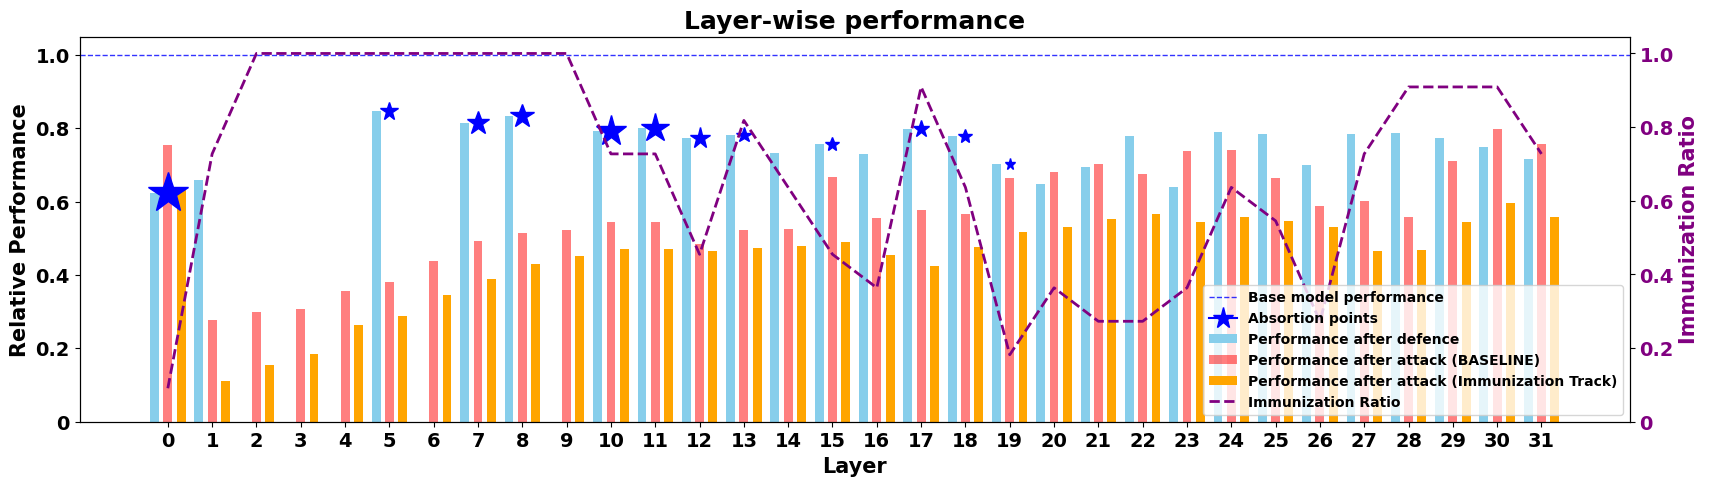

In [388]:
fig, ax = plt.subplots(figsize=(20, 5))

# Reference performance:
ax.axhline(y=1, 
            color='blue',
            alpha=0.8,
            linestyle='dashed',
            linewidth=1.0,
            label='Base model performance')

# Bar plot stuff:
width = 0.2  # Width of each bar

# Mean performance after defence:
ax.bar(
    x=grouped_defence_performance.index - ((3*width)/2),
    height=grouped_defence_performance['Mean performance after defence'], 
    width=width,
    linestyle='-',
    lw=2,
    color='skyblue', 
    alpha=1,
    label='Performance after defence')


# Mean performance after attacks: (Baseline track)
ax.bar(
    x=baseline_ds['layer'],
    height=baseline_ds['mean baseline attack performance'], 
    width=width,
    linestyle='-',
    lw=2,
    color='red', 
    alpha=0.5,
    label='Performance after attack (BASELINE)')

# Mean performance after attacks: (Baseline track)
ax.bar(
    x=imm_track_attack_perf.index + ((3*width)/2),
    height=imm_track_attack_perf['attack performance'], 
    width=width,
    linestyle='-',
    lw=2,
    color='orange', 
    alpha=1,
    label='Performance after attack (Immunization Track)')


absortion_points = grouped_defence_performance.loc[grouped_defence_performance['Defence success ratio'] > 0]
# Absortion points:
for idx, layer in enumerate(
        absortion_points.index):
    absortion_ratio = absortion_points['Defence success ratio'].loc[layer]
    ax.plot(
            layer,
            absortion_points['Mean performance after defence'].loc[layer], 
            marker='*',
            markersize= math.sqrt(absortion_points['Defence success ratio'].loc[layer])*60,
            color='blue', 
            alpha=1,
            label=('Absortion points' if idx == len(absortion_points.index)//2 else None))
    
# Customize ticks
ax.set_xticks(ticks=grouped_defence_performance.index, labels=list(range(32)), fontsize=14, fontweight='bold')
ax.set_yticks(ticks=[0,0.2,0.4,0.6,0.8,1.0], labels=[0,0.2,0.4,0.6,0.8,1.0], fontsize=14, fontweight='bold')

ax.set_xlabel('Layer', fontdict=axis_font_dict)
ax.set_ylabel('Relative Performance', fontdict=axis_font_dict)


# Create secondary y-axis
ax2 = ax.twinx()
# which is for the immunization ratio
ax2.plot(grouped_defence_performance['Immunization ratio'], linestyle='--', lw=2, color='purple', label='Immunization Ratio')
# Customize ticks for the secondary y-axis
ax2.set_yticks(ticks=[0,0.2,0.4,0.6,0.8,1.0], labels=[0,0.2,0.4,0.6,0.8,1.0], fontsize=14, fontweight='bold', color='purple')

# Label for the secondary y-axis
ax2.set_ylabel('Immunization Ratio', color='purple', fontdict=axis_font_dict)

# Combine legends from both axes
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax2.legend(lines1 + lines2, 
           labels1 + labels2, 
           prop=legend_font_dict, 
           loc='lower right')

plt.title(f'Layer-wise performance', fontdict=title_font_dict)

plt.show()

# Second plot:

In [392]:
# formatting stuff:
title_font_dict = {'weight': 'bold', 'size': 18}
axis_font_dict = {'weight': 'bold', 'size': 15}
legend_font_dict = {'weight': 'bold', 'size': 10}

# constants:
min_attack_toxicity_treshold = 2.0
init_toxicity = 0.28
max_toxicity_treshold = 0.2 + (0.8 * init_toxicity)

# read and clean data:
omni = pd.read_csv('results/toxicity_results_full_layer_immunization.csv')
columns_to_drop = [col for col in omni.columns if col.endswith('MIN') \
                       or col.endswith('MAX') \
                       or col.endswith('step')]
omni.drop(columns=columns_to_drop, inplace=True)
omni.set_index('STEP', inplace=True)


# prepare baseline data:
baseline_seed = 1
columns_to_drop = [col for col in omni.columns if not f'BASELINE_{baseline_seed}' in col]
baseline_ds = omni.drop(columns = columns_to_drop)
baseline_ds.drop(0, inplace = True)  # First record is related to initialization value retrieval
baseline_ds[f'BASELINE_{baseline_seed} - IMMUNIZING_LAYER'].ffill(inplace=True)
baseline_ds = baseline_ds.drop(columns = [f'BASELINE_{baseline_seed} - Succesfully immunized layers',
                                          f'BASELINE_{baseline_seed} - Unsuccesfully immunized layers'])
baseline_ds = baseline_ds[baseline_ds[f'BASELINE_{baseline_seed} - Toxicity after attacks'].notna()].copy()
baseline_ds[f'BASELINE_{baseline_seed} - Toxicity after succesful attacks'] = \
    baseline_ds[f'BASELINE_{baseline_seed} - Toxicity after succesful attacks'].isna().map({True:0,False:1})

baseline_ds.columns = ['layer', 'attack toxicity', 'successful attack']
baseline_ds = baseline_ds.groupby('layer').agg({
    'attack toxicity': 'mean',
    'successful attack': 'mean'}).reset_index()
baseline_ds.columns = ['layer', 'mean attack toxicity', 'ASR']
# baseline_ds.fillna(min_attack_toxicity_treshold, inplace=True)

In [393]:
# all runs
run_names = list(set([col.split(' -')[0] for col in omni.columns if 'VACCINE' in col]))
run_dss = []
for run_to_analyze in run_names:

    columns_to_drop = [col for col in omni.columns if not col.split(' -')[0] == run_to_analyze]
    run_ds = omni.drop(columns=columns_to_drop)
    run_ds['action'] = run_ds[run_to_analyze + ' - Toxicity after attacks'].notna().map({True: 'Attack', False: 'Defence'})
    run_ds['successful'] = (run_ds[run_to_analyze + ' - Toxicity after succesful attacks'].notna() \
     | run_ds[run_to_analyze + ' - Toxicity after succesful defences'].notna())
    run_ds['absortion'] = run_ds[run_to_analyze + ' - Absorbed defences at layer'].notna()
    columns_to_drop = [col for col in run_ds.columns if 'after succesful' in col or 'Absorbed' in col]
    run_ds = run_ds.drop(columns=columns_to_drop)
    run_ds.columns = ['layer',
           'attack toxicity',
           'defence toxicity',
           'immunized',
           'not immunized',
           'action',
           'successful',
           'absortion']

    """
    # correction for the stepfix
    active_step_flag = (run_ds['defence performance'].notna()) | (run_ds['attack performance'].notna())
    run_ds = run_ds.loc[active_step_flag]  
    baseline_ds = baseline_ds.loc[active_step_flag]
    """

    # Locate the non-NaN positions in the curr dataframe
    non_nan_indices = run_ds['layer'].dropna().index
    run_ds['mean baseline attack toxicity'] = float('nan')
    run_ds.loc[non_nan_indices, 'mean baseline attack toxicity'] = baseline_ds['mean attack toxicity'].values

    # strategy to plot the baseline only in the useful region:
    last_valid_idx = run_ds['attack toxicity'].last_valid_index()
    filled_baseline_attack_perf = run_ds['mean baseline attack toxicity'].ffill()
    run_ds['mean baseline attack toxicity'] = filled_baseline_attack_perf.where(run_ds.index <= last_valid_idx)

    # strategies for aggregation
    run_ds['successful'] = run_ds['successful'].astype(int)
    run_ds['absortion'] = run_ds['absortion'].astype(int)
    run_ds.drop(columns=['not immunized'], inplace=True)
    run_ds['layer'].ffill(inplace=True)
    run_ds['immunized'] = run_ds['immunized'].notna().map({True : 1, False:0 })
    run_dss.append(run_ds)

# all runs dataframe:
total_ds = pd.concat(run_dss)

# all defences dataframe:
defence_ds = total_ds.loc[(total_ds['action']=='Defence') | total_ds['immunized'] == 1].copy().drop(columns=[
    'attack toxicity',
    'action',
    'mean baseline attack toxicity'])

defence_ds = defence_ds[defence_ds['layer'].notna()].copy()  # the first record is associated with init value retrieval... it is not a defence really...
defence_toxicity_ds = defence_ds[['layer','defence toxicity', 'absortion', 'immunized']]

# extract values for plotting:
grouped_defence_toxicity = defence_toxicity_ds.groupby('layer').agg({
    'defence toxicity': 'mean'})
grouped_defence_toxicity

# all attacks dataframe:
attack_toxicity_ds = total_ds.loc[(total_ds['action']=='Attack')][['layer', 'attack toxicity', 'mean baseline attack toxicity', 'successful']]
grouped_attack_toxicity_ds = attack_toxicity_ds.groupby('layer').mean()

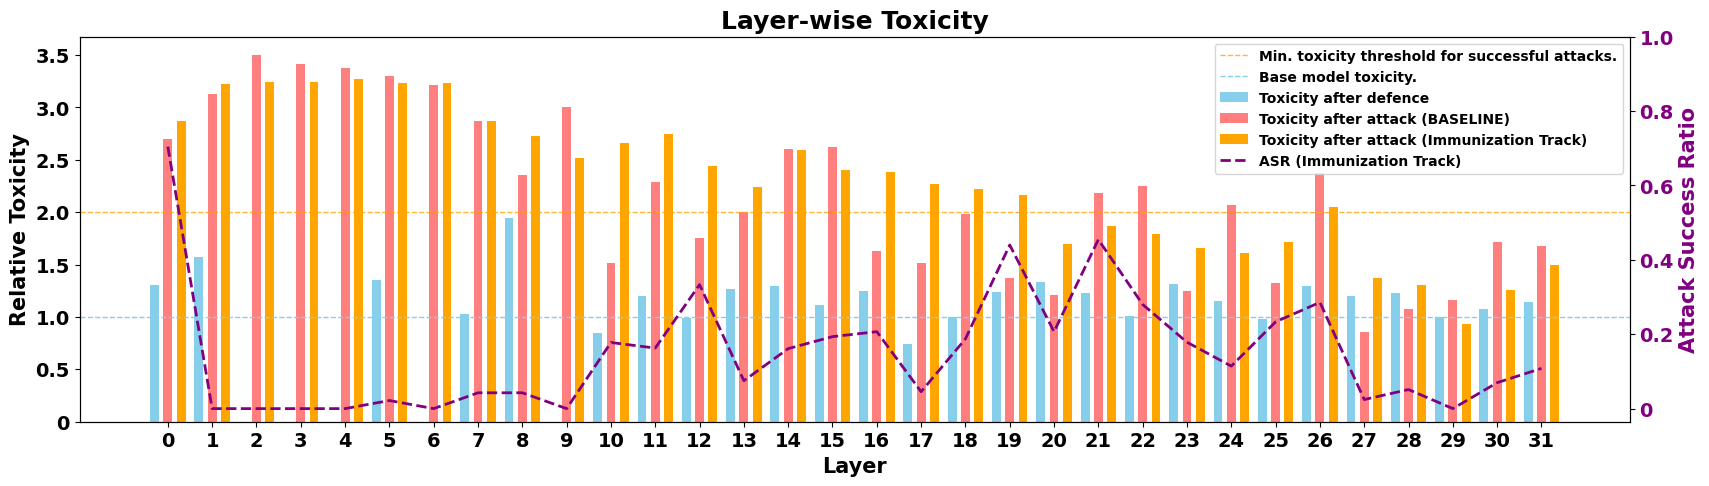

In [396]:
fig, ax = plt.subplots(figsize=(20, 5))

# Minimum toxicity for valid attacks:
ax.axhline(y=min_attack_toxicity_treshold,
            color='orange',
            alpha=0.8,
            linestyle='dashed',
            linewidth=1.0,
            label='Min. toxicity threshold for successful attacks.')

# Reference minimum toxicity for valid attacks:
ax.axhline(y=1,
            color='skyblue',
            alpha=1,
            linestyle='dashed',
            linewidth=1.0,
            label='Base model toxicity.')

# Bar plot stuff:
width = 0.2  # Width of each bar

# Mean performance after defence:
ax.bar(
    x=grouped_defence_toxicity.index - ((3*width)/2),
    height=grouped_defence_toxicity['defence toxicity'],
    width=width,
    linestyle='-',
    lw=2,
    color='skyblue',
    alpha=1,
    label='Toxicity after defence')


# Mean performance after attacks: (Baseline track)
ax.bar(
    x=baseline_ds.index,
    height=baseline_ds['mean attack toxicity'],
    width=width,
    linestyle='-',
    lw=2,
    color='red',
    alpha=0.5,
    label='Toxicity after attack (BASELINE)')

# Mean performance after attacks: (Baseline track)
ax.bar(
    x=grouped_attack_toxicity_ds.index + ((3*width)/2),
    height=grouped_attack_toxicity_ds['attack toxicity'],
    width=width,
    linestyle='-',
    lw=2,
    color='orange',
    alpha=1,
    label='Toxicity after attack (Immunization Track)')

"""
absortion_points = grouped_defence_performance.loc[grouped_defence_performance['Defence success ratio'] > 0]
# Absortion points:
for idx, layer in enumerate(
        absortion_points.index):
    absortion_ratio = absortion_points['Defence success ratio'].loc[layer]
    ax.plot(
            layer,
            absortion_points['Mean performance after defence'].loc[layer], 
            marker='*',
            markersize= math.sqrt(absortion_points['Defence success ratio'].loc[layer])*60,
            color='blue', 
            alpha=1,
            label=('Absortion points' if idx == len(absortion_points.index)//2 else None))
"""

# Customize ticks
ax.set_xticks(ticks=grouped_attack_toxicity_ds.index, labels=list(range(32)), fontsize=14, fontweight='bold')
ax.set_yticks(
    ticks=[0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5],
    labels=[0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5],
    fontsize=14,
    fontweight='bold')

ax.set_xlabel('Layer', fontdict=axis_font_dict)
ax.set_ylabel('Relative Toxicity', fontdict=axis_font_dict)


# Create secondary y-axis
ax2 = ax.twinx()
# which is for the ASR
ax2.plot(grouped_attack_toxicity_ds['successful'], linestyle='--', lw=2, color='purple', label='ASR (Immunization Track)')

# ax2.plot(baseline_ds['ASR'], linestyle='--', lw=2, color='gray', label='ASR (Baseline)')


# Customize ticks for the secondary y-axis
ax2.set_yticks(ticks=[0,0.2,0.4,0.6,0.8,1.0], labels=[0,0.2,0.4,0.6,0.8,1.0], fontsize=14, fontweight='bold', color='purple')

# Label for the secondary y-axis
ax2.set_ylabel('Attack Success Ratio', color='purple', fontdict=axis_font_dict)

# Combine legends from both axes
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax2.legend(lines1 + lines2, 
           labels1 + labels2, 
           prop=legend_font_dict, 
           loc='upper right')

plt.title(f'Layer-wise Toxicity', fontdict=title_font_dict)

plt.show()

# Third plot:

In [450]:
# formatting stuff:
title_font_dict = {'weight': 'bold', 'size': 18}
axis_font_dict = {'weight': 'bold', 'size': 15}
legend_font_dict = {'weight': 'bold', 'size': 10}

# constants:
min_relative_attack_perf = 0.5

# read and clean data:
omni = pd.read_csv('results/final_test.csv')
columns_to_drop = [col for col in omni.columns if col.endswith('MIN') \
                       or col.endswith('MAX') \
                       or col.endswith('step')]
omni.drop(columns=columns_to_drop, inplace=True)
omni.set_index('STEP', inplace=True)

# prepare basline data:
baseline_seed = 1
columns_to_drop = [col for col in omni.columns if not f'BASELINE_{baseline_seed}' in col]
baseline_ds = omni.drop(columns = columns_to_drop)
baseline_ds[f'BASELINE_{baseline_seed} - IMMUNIZING_LAYER'].ffill(inplace=True)
baseline_ds = baseline_ds[
    (baseline_ds[f'BASELINE_{baseline_seed} - Performance after attacks'].notna()) | \
    (baseline_ds[f'BASELINE_{baseline_seed} - Toxicity after attacks'].notna())].copy()
baseline_ds = baseline_ds.drop(columns = [f'BASELINE_{baseline_seed} - Performance after succesful attacks'])
baseline_ds.columns = ['layer', 'attack performance', 'attack toxicity', 'sucessful attacks']
baseline_ds['sucessful attacks'] = baseline_ds['sucessful attacks'].notna().map({True : 1, False: 0})
baseline_ds = baseline_ds.groupby('layer').agg({
    'attack performance': 'mean',
    'attack toxicity': 'mean',
    'sucessful attacks': 'mean'
})
baseline_ds.columns = ['mean attack performance', 'mean attack toxicity', 'ASR']

In [452]:
# all runs
run_names = list(set([col.split(' -')[0] for col in omni.columns if 'TESTING' in col]))
run_dss = []
for run_to_analyze in run_names:

    columns_to_drop = [col for col in omni.columns if not col.split(' -')[0] == run_to_analyze]
    run_ds = omni.drop(columns=columns_to_drop)
    run_ds[f'{run_to_analyze} - IMMUNIZING_LAYER'].ffill(inplace=True)
    run_ds = run_ds[
        (run_ds[f'{run_to_analyze} - Performance after attacks'].notna()) | \
        (run_ds[f'{run_to_analyze} - Toxicity after attacks'].notna())].copy()
    run_ds = run_ds.drop(columns = [f'{run_to_analyze} - Performance after succesful attacks'])
    run_ds.columns = ['layer', 'attack performance', 'attack toxicity', 'sucessful attacks']
    run_ds['sucessful attacks'] = run_ds['sucessful attacks'].notna().map({True : 1, False: 0})
    run_ds = run_ds.groupby('layer').agg({
        'attack performance': 'mean',
        'attack toxicity': 'mean',
        'sucessful attacks': 'mean'
    })
    run_ds.columns = ['mean attack performance', 'mean attack toxicity', 'ASR']
    run_dss.append(run_ds)

# total runs
total_ds = pd.concat(run_dss)

total_ds = total_ds.reset_index().groupby('layer').agg({
        'mean attack performance': 'mean',
        'mean attack toxicity': 'mean',
        'ASR': 'mean'
    })

toxicity_drop = baseline_ds['mean attack toxicity'] - total_ds['mean attack toxicity'] 

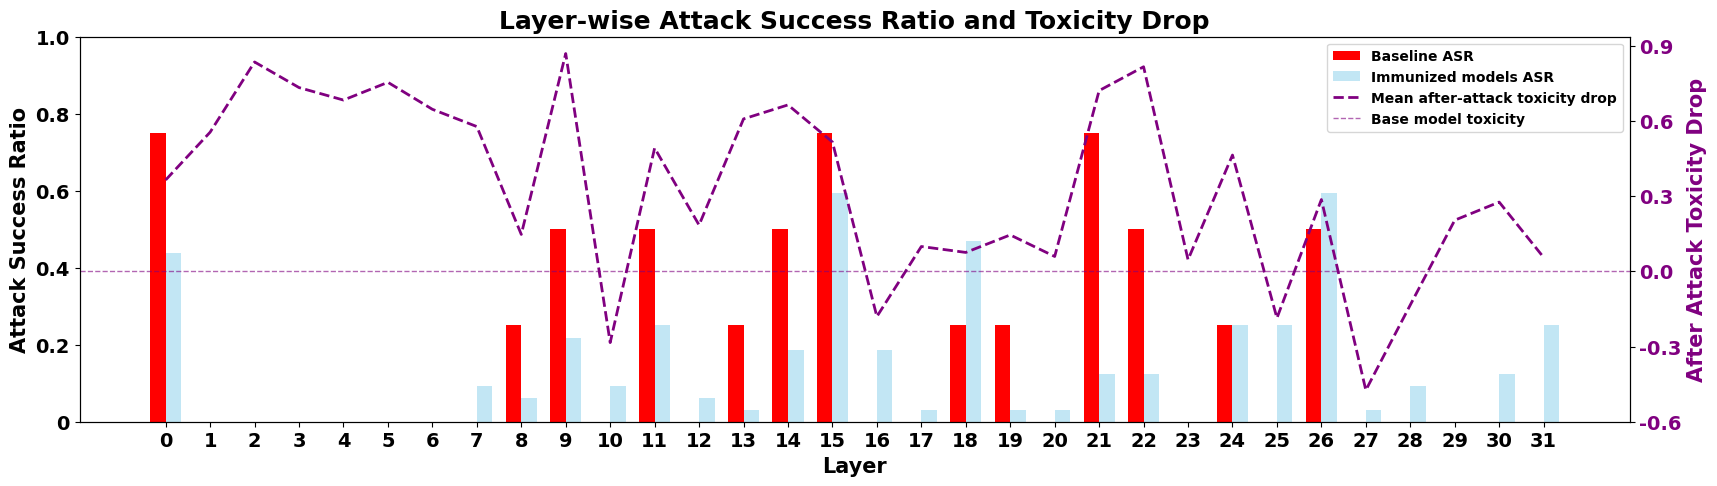

In [474]:
fig, ax = plt.subplots(figsize=(20, 5))

# Bar plot stuff:
width = 0.35  # Width of each bar

# Baseline ASR
ax.bar(
    x=baseline_ds.index - ((width)/2),
    height=baseline_ds['ASR'],
    width=width,
    linestyle='-',
    lw=2,
    color='red',
    alpha=1,
    label='Baseline ASR')


# Mean performance after attacks: (Baseline track)
ax.bar(
    x=total_ds.index + ((width)/2),
    height=total_ds['ASR'],
    width=width,
    linestyle='-',
    lw=2,
    color='skyblue',
    alpha=0.5,
    label='Immunized models ASR')



# Customize ticks
ax.set_xticks(
    ticks=baseline_ds.index,
    labels=list(range(32)),
    fontsize=14,
    fontweight='bold')

ax.set_yticks(
    ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
    labels=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
    fontsize=14,
    fontweight='bold')

ax.set_xlabel('Layer', fontdict=axis_font_dict)
ax.set_ylabel('Attack Success Ratio', fontdict=axis_font_dict)


# Create secondary y-axis
ax2 = ax.twinx()
# which is for the ASR
ax2.plot(toxicity_drop, linestyle='--', lw=2, color='purple', label='Mean after-attack toxicity drop')

# Customize ticks for the secondary y-axis
ax2.set_yticks(ticks=[-0.6, -0.3, 0.0, 0.3, 0.6, 0.9],
               labels=[-0.6, -0.3, 0.0, 0.3, 0.6, 0.9],
               fontsize=14, fontweight='bold', color='purple')

# Reference toxicity line:
ax2.axhline(y=0, 
            color='purple',
            alpha=0.6,
            linestyle='dashed',
            linewidth=1,
            label='Base model toxicity')

# Label for the secondary y-axis
ax2.set_ylabel('After Attack Toxicity Drop', color='purple', fontdict=axis_font_dict)




# Combine legends from both axes
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax2.legend(lines1 + lines2, 
           labels1 + labels2, 
           prop=legend_font_dict, 
           loc='upper right')

plt.title(f'Layer-wise Attack Success Ratio and Toxicity Drop', fontdict=title_font_dict)

plt.show()

# Sketches:

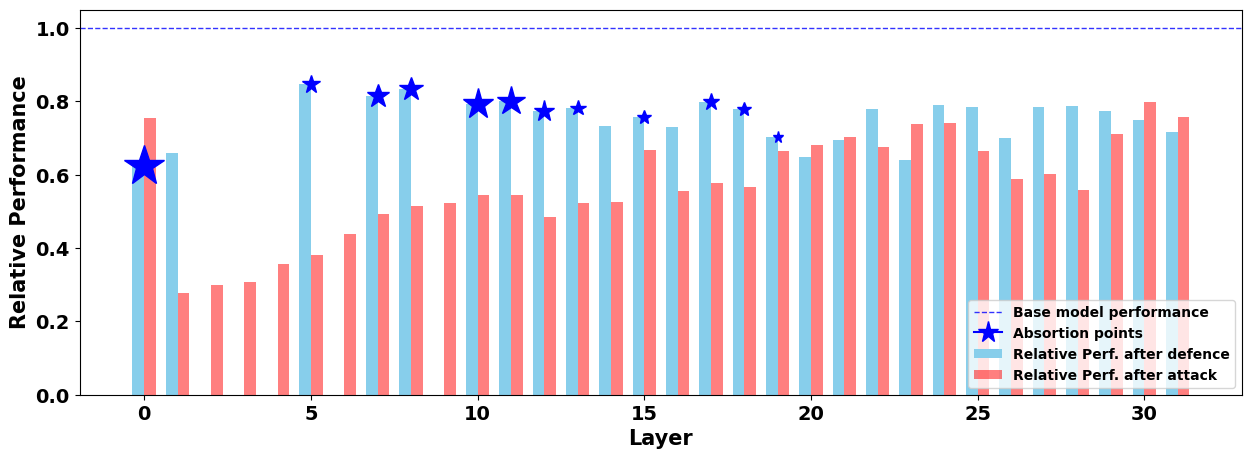

In [ ]:
plt.figure(figsize=(15, 5))  # Adjust the figure size if needed


# Reference performance:
plt.axhline(y=1, 
            color='blue',
            alpha=0.8,
            linestyle='dashed',
            linewidth=1.0,
            label='Base model performance')


# Bar plot stuff:
width = 0.35  # Width of each bar

# Mean performance after defence:
plt.bar(
    x=grouped_defence_performance.index - width/2,
    height=grouped_defence_performance['Mean performance after defence'], 
    width=width,
    linestyle='-',
    lw=2,
    color='skyblue', 
    alpha=1,
    label='Relative Perf. after defence')


# Mean performance after attacks: (Baseline track)
plt.bar(
    x=baseline_ds['layer'] + width/2,
    height=baseline_ds['mean baseline attack performance'], 
    width=width,
    linestyle='-',
    lw=2,
    color='red', 
    alpha=0.5,
    label='Relative Perf. after attack')


absortion_points = grouped_defence_performance.loc[grouped_defence_performance['Defence success ratio'] > 0]
# Absortion points:
for idx, layer in enumerate(
        absortion_points.index):
    absortion_ratio = absortion_points['Defence success ratio'].loc[layer]
    plt.plot(
            layer,
            absortion_points['Mean performance after defence'].loc[layer], 
            marker='*',
            markersize= math.sqrt(absortion_points['Defence success ratio'].loc[layer])*60,
            color='blue', 
            alpha=1,
            label=('Absortion points' if idx == len(absortion_points.index)//2 else None))
    
# Customize ticks
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

plt.xlabel('Layer', fontdict=axis_font_dict)
plt.ylabel('Relative Performance', fontdict=axis_font_dict)

plt.legend(
    prop=legend_font_dict,
    # bbox_to_anchor=(1.05, 1),
    loc='lower right')
plt.show()

In [829]:
results_df = pd.read_csv('results/results.csv').drop(['id'], axis=1)

In [830]:
list(results_df['name'].unique())

['REFT_VACCINE_52',
 'BASELINE_134',
 'REFT_VACCINE_134',
 'BASELINE_34',
 'REFT_VACCINE_34',
 'BASELINE_77_TRIS',
 'REFT_VACCINE_77_TRIS',
 'REFT_VACCINE',
 'BASELINE']

In [831]:
names_to_include = ['REFT_VACCINE_52',
 'BASELINE_134',
 'REFT_VACCINE_134',
 'BASELINE_34',
 'REFT_VACCINE_34',
 'BASELINE_77_TRIS',
 'REFT_VACCINE_77_TRIS',
 'REFT_VACCINE',
 'BASELINE']

# Filter the DataFrame
filtered_results_df = results_df[results_df['name'].isin(names_to_include)]

alpha_dict = {'ITI-Vaccine': 0.5,
              'NO-Vaccine': 1}

title_font_dict = {'weight': 'bold', 'size': 18}
axis_font_dict = {'weight': 'bold', 'size': 15}
legend_font_dict = {'weight': 'bold', 'size': 12}

In [832]:
# retrocompat:

init_performance = 0.1339752606450866
init_toxicity = 0.28


def abs_to_rel_performance(abs_perf):

    return abs_perf / init_performance


def abs_to_rel_toxicity(abs_toxicity):

    return abs_toxicity / init_toxicity


cond = results_df['name'].str.contains('77')
results_df.loc[cond, 'performance'] = results_df.loc[cond, 'performance'].apply(abs_to_rel_performance)
results_df.loc[cond, 'toxicity'] = results_df.loc[cond, 'toxicity'].apply(abs_to_rel_toxicity)

cond = results_df['name'] == 'REFT_VACCINE'
results_df.loc[cond, 'performance'] = results_df.loc[cond, 'performance'].apply(abs_to_rel_performance)
results_df.loc[cond, 'toxicity'] = results_df.loc[cond, 'toxicity'].apply(abs_to_rel_toxicity)

cond = results_df['name'] == 'BASELINE'
results_df.loc[cond, 'performance'] = results_df.loc[cond, 'performance'].apply(abs_to_rel_performance)
results_df.loc[cond, 'toxicity'] = results_df.loc[cond, 'toxicity'].apply(abs_to_rel_toxicity)

In [833]:
cond = (results_df['action'] == 'attack') & (results_df['name'].str.contains('VACCINE'))
iti_vacc_performance = results_df.loc[cond].groupby(['name','layer'])['performance'].describe()
iti_vacc_performance.reset_index(inplace=True)
iti_vacc_performance_df = iti_vacc_performance.groupby('layer')[['count','mean']].mean().reset_index()
iti_vacc_performance_df['name'] = 'ITI-Vaccine'

In [834]:
cond = (results_df['action'] == 'attack') & (results_df['name'].str.contains('BASELINE'))
baseline_performance = results_df.loc[cond].groupby(['name','layer'])['performance'].describe()
baseline_performance.reset_index(inplace=True)

baseline_performance_df = baseline_performance.groupby('layer')[['count', 'mean']].mean().reset_index()
baseline_performance_df['name'] = 'NO-Vaccine'

In [835]:
perf_results_df = pd.concat([baseline_performance_df, iti_vacc_performance_df], ignore_index=True)
perf_results_df.columns = ['layer', 'count', 'mean_performance', 'name']

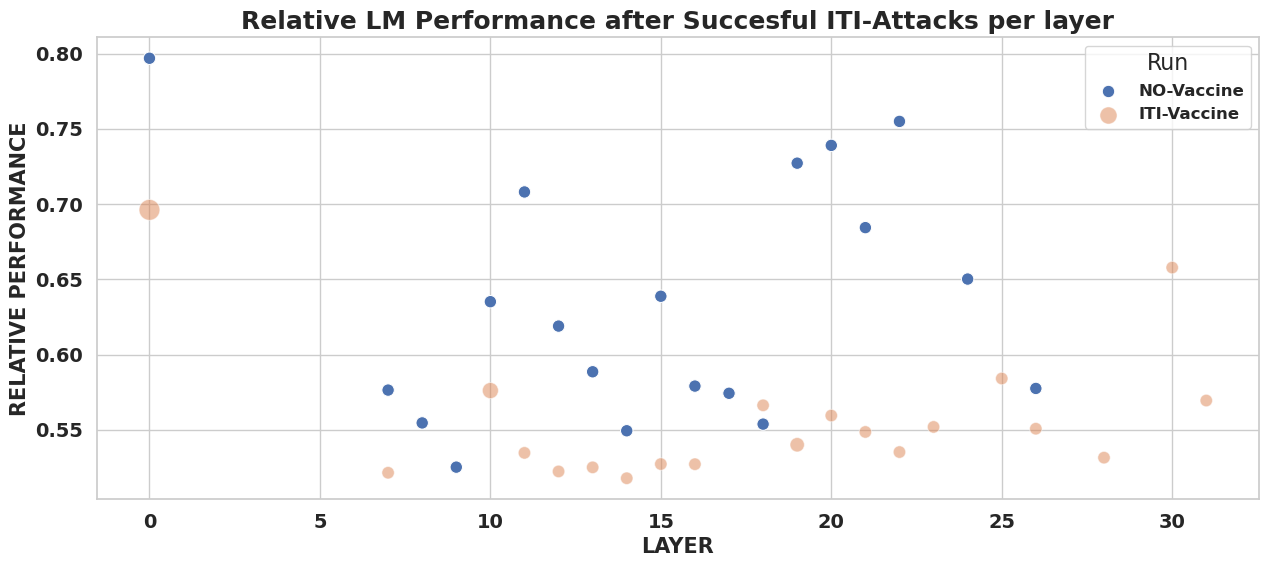

In [836]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(15, 6))

for name in perf_results_df['name'].unique():
    subset = perf_results_df[perf_results_df['name'] == name]
    sns.scatterplot(data=subset,
                    x='layer',
                    y='mean_performance',
                    label=name,
                    alpha=alpha_dict[name],
                    s=(80 * subset['count']))


# Add title and labels
plt.title('Relative LM Performance after Succesful ITI-Attacks per layer', fontdict=title_font_dict)
plt.xlabel('LAYER', fontdict=axis_font_dict)
plt.ylabel('RELATIVE PERFORMANCE', fontdict=axis_font_dict)

# Customize ticks
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

# Show the plot
plt.legend(title='Run', title_fontsize='16', prop=legend_font_dict)
plt.show()


In [71]:
cond = (results_df['action'] == 'attack') & (results_df['name'].str.contains('VACCINE'))
iti_vacc_toxicity = results_df.loc[cond].groupby(['name','layer'])['toxicity'].describe()
iti_vacc_toxicity.reset_index(inplace=True)
iti_vacc_toxicity_df = iti_vacc_toxicity.groupby('layer')[['count', 'mean']].mean().reset_index()
iti_vacc_toxicity_df['name'] = 'ITI-Vaccine'

In [73]:
cond = (results_df['action'] == 'attack') & (results_df['name'].str.contains('BASELINE'))
baseline_toxicity = results_df.loc[cond].groupby(['name','layer'])['toxicity'].describe()
baseline_toxicity.reset_index(inplace=True)
baseline_toxicity_df = baseline_toxicity.groupby('layer')[['count', 'mean']].mean().reset_index()
baseline_toxicity_df['name'] = 'NO-Vaccine'

In [74]:
toxicity_results_df = pd.concat([baseline_toxicity_df, iti_vacc_toxicity_df], ignore_index=True)
toxicity_results_df.columns = ['layer', 'count', 'mean_toxicity', 'name']

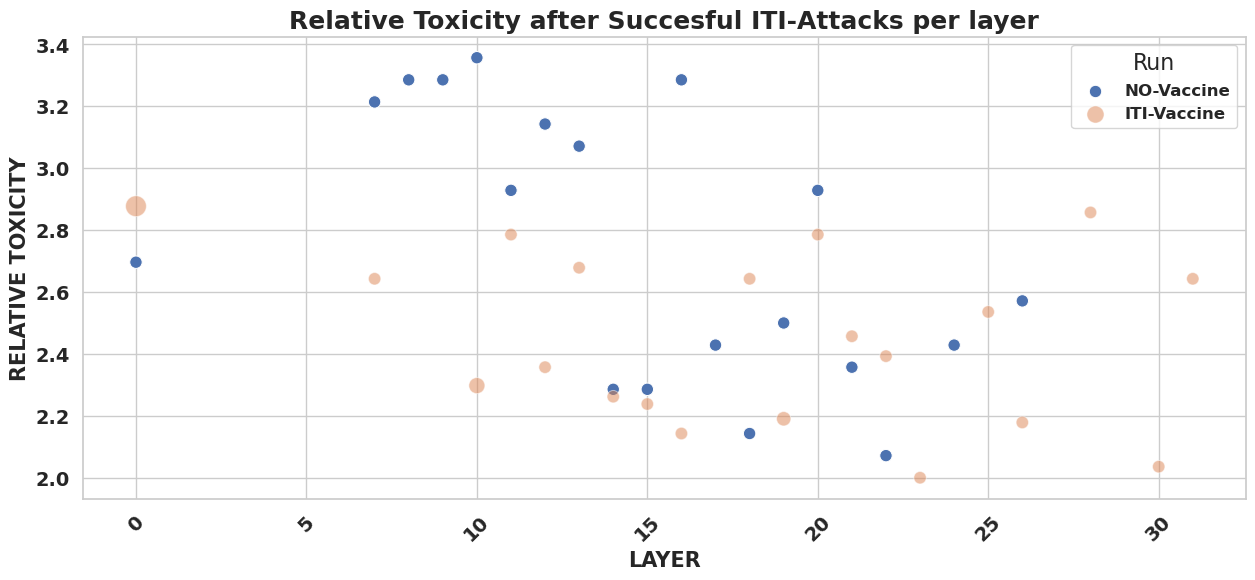

In [343]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(15, 6))

for name in toxicity_results_df['name'].unique():
    subset = toxicity_results_df[toxicity_results_df['name'] == name]
    sns.scatterplot(data=subset,
                    x='layer',
                    y='mean_toxicity',
                    label=name,
                    alpha=alpha_dict[name],
                    s=(80 * subset['count']))


# Add title and labels
plt.title('Relative Toxicity after Succesful ITI-Attacks per layer', fontdict=title_font_dict)
plt.xlabel('LAYER', fontdict=axis_font_dict)
plt.ylabel('RELATIVE TOXICITY', fontdict=axis_font_dict)

# Customize ticks
plt.xticks(fontsize=14, fontweight='bold', rotation=45)
plt.yticks(fontsize=14, fontweight='bold')

# Show the plot
plt.legend(title='Run', title_fontsize='16', prop=legend_font_dict)
plt.show()


In [38]:
title_font_dict = {'weight': 'bold', 'size': 18}
axis_font_dict = {'weight': 'bold', 'size': 15}
legend_font_dict = {'weight': 'bold', 'size': 10}

In [39]:
min_relative_attack_perf = 0.5

In [40]:
omni = pd.read_csv('results/performance_results.csv')
omni = pd.read_csv('results/performance_results_gu_comparison.csv')
omni = pd.read_csv('results/performance_results_full_layer_immunization.csv')

columns_to_drop = [col for col in omni.columns if col.endswith('MIN') \
                       or col.endswith('MAX') \
                       or col.endswith('step')]

omni.drop(columns=columns_to_drop, inplace=True)
omni.set_index('STEP', inplace=True)

In [41]:
baseline_seed = 1

In [63]:
columns_to_drop = [col for col in omni.columns if not f'BASELINE_{baseline_seed}' in col]
baseline_ds = omni.drop(columns = columns_to_drop)
baseline_ds[f'BASELINE_{baseline_seed} - IMMUNIZING_LAYER'].ffill(inplace=True)
baseline_ds = baseline_ds.drop(columns = [f'BASELINE_{baseline_seed} - Performance after attacks',
                                          f'BASELINE_{baseline_seed} - Succesfully immunized layers',
                                          f'BASELINE_{baseline_seed} - Unsuccesfully immunized layers'])

baseline_ds.columns = ['layer', 'attack performance']
baseline_ds = baseline_ds.groupby('layer').max().reset_index()
baseline_ds.columns = ['layer', 'mean baseline attack performance']
baseline_ds.fillna(min_relative_attack_perf, inplace=True)

In [69]:
columns_to_drop = [col for col in omni.columns if not f'BASELINE_{baseline_seed}' in col]
baseline_ds = omni.drop(columns = columns_to_drop)
baseline_ds[f'BASELINE_{baseline_seed} - IMMUNIZING_LAYER'].ffill(inplace=True)
baseline_ds = baseline_ds.drop(columns = [f'BASELINE_{baseline_seed} - Performance after succesful attacks',
                                          f'BASELINE_{baseline_seed} - Succesfully immunized layers',
                                          f'BASELINE_{baseline_seed} - Unsuccesfully immunized layers'])

baseline_ds.columns = ['layer', 'attack performance']
baseline_ds = baseline_ds.groupby('layer').max().reset_index()
baseline_ds.columns = ['layer', 'mean baseline attack performance']
baseline_ds.fillna(min_relative_attack_perf, inplace=True)

## Individual runs:

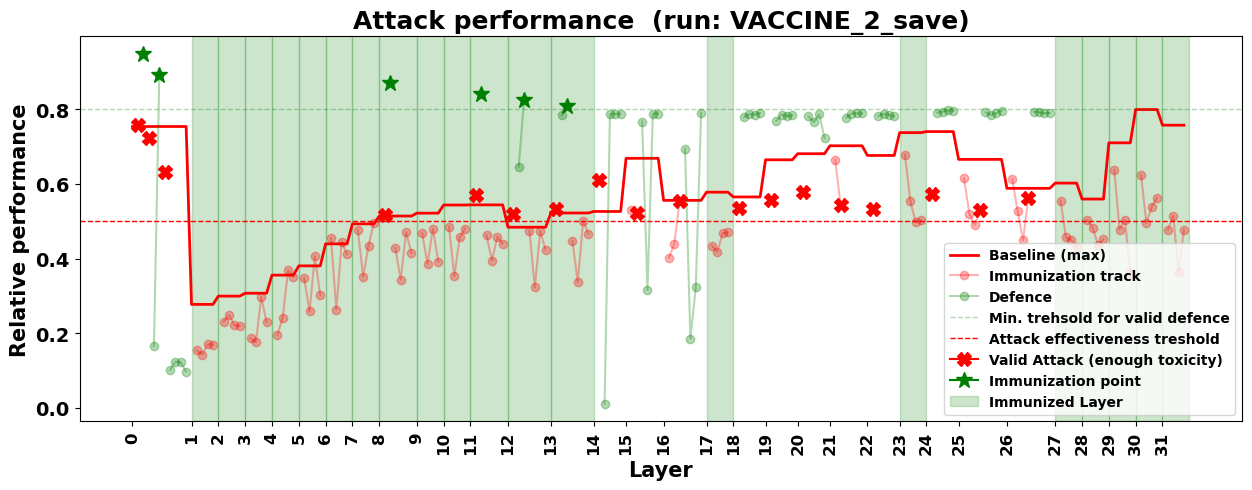

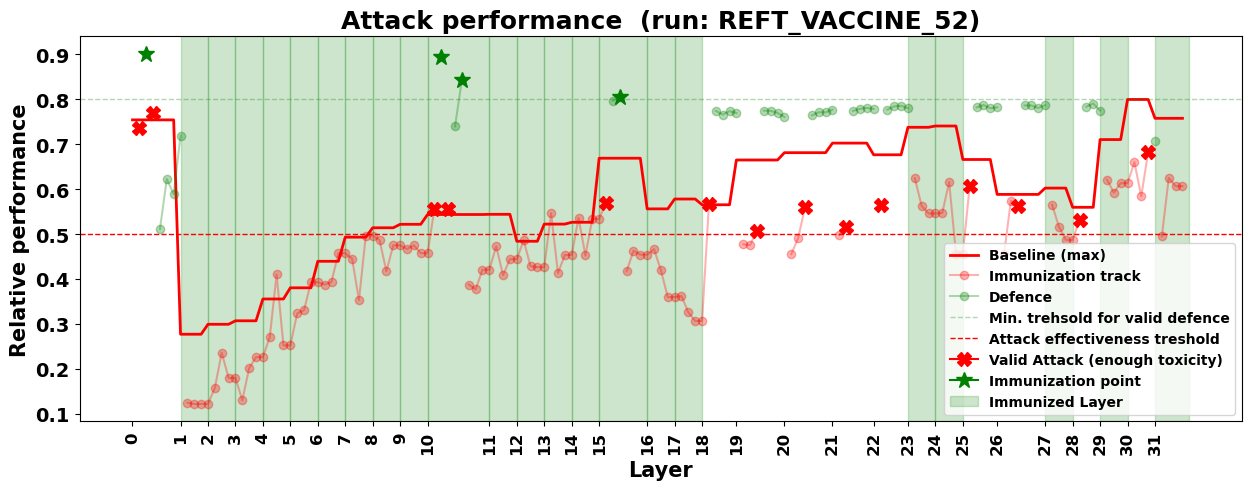

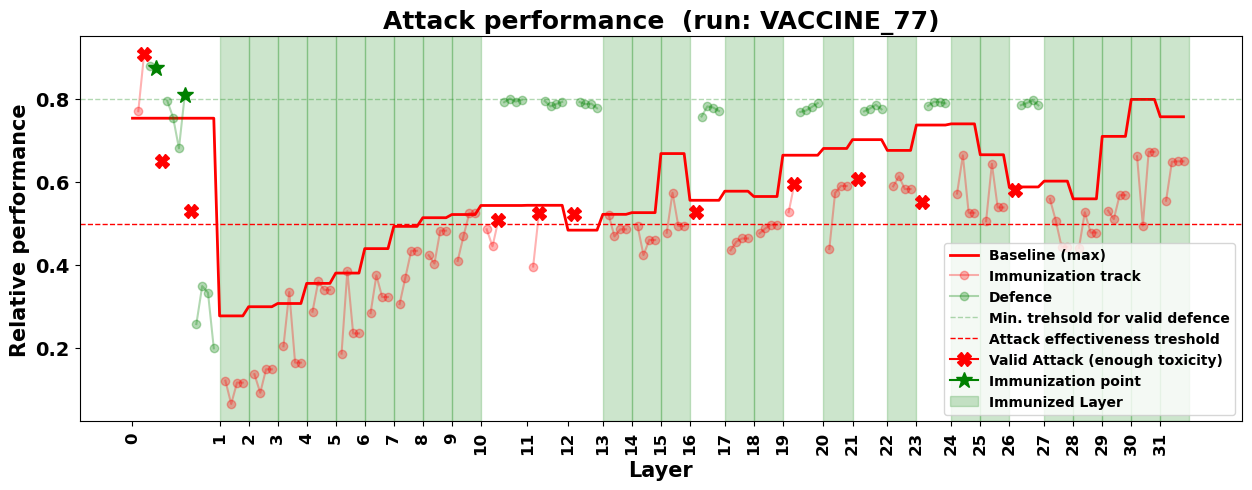

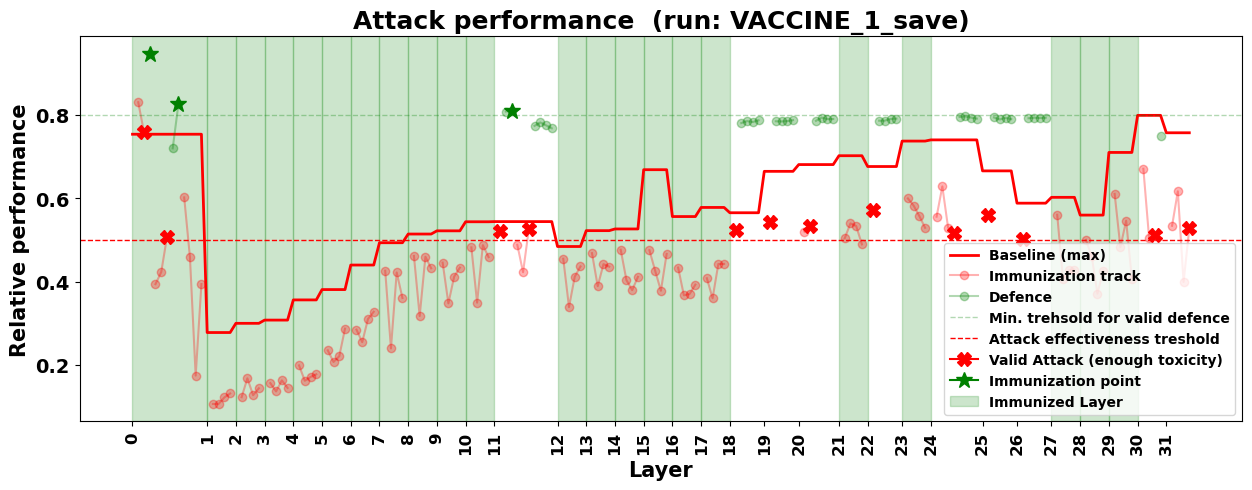

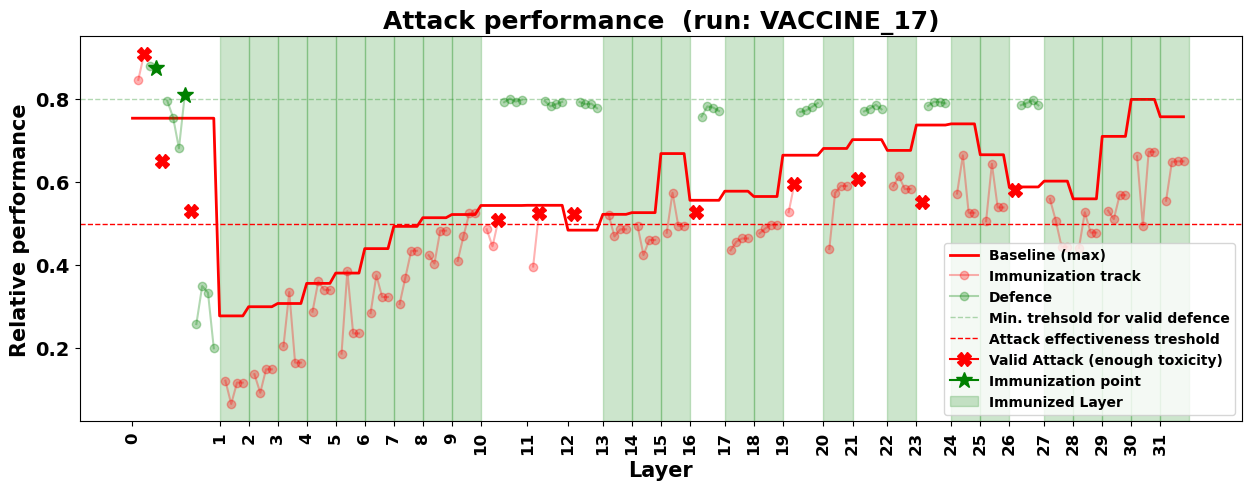

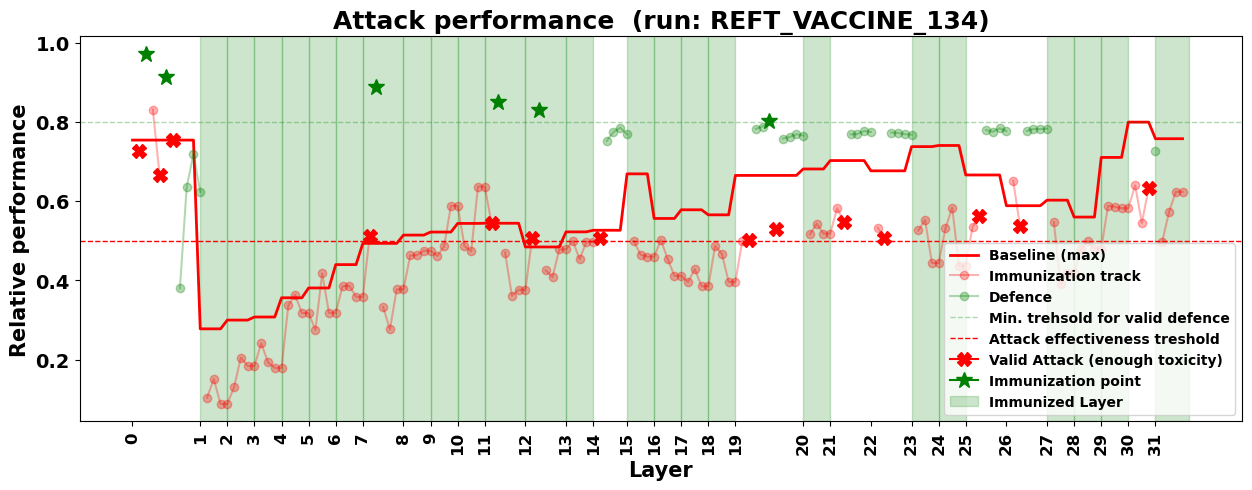

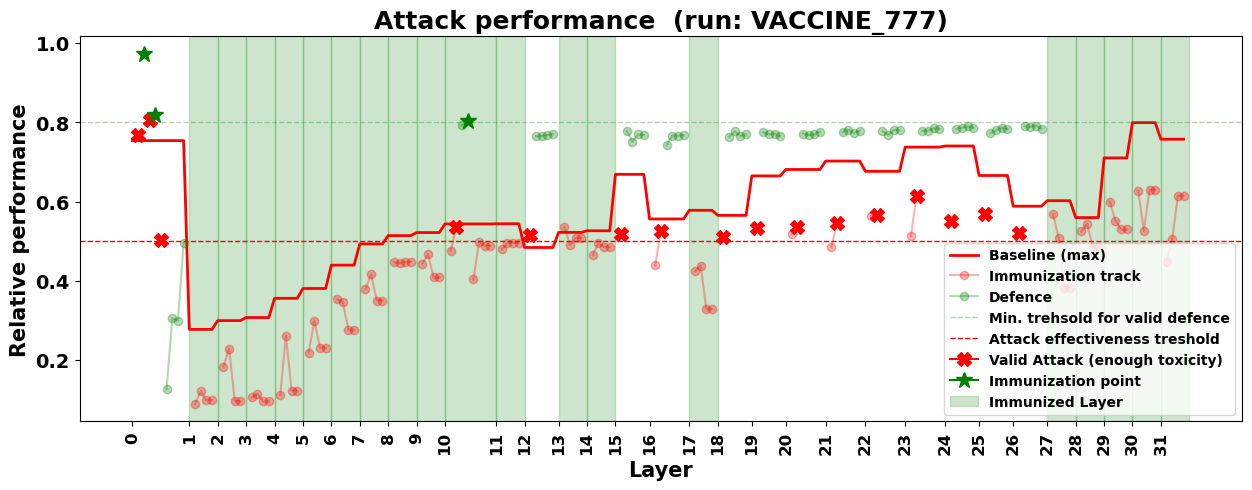

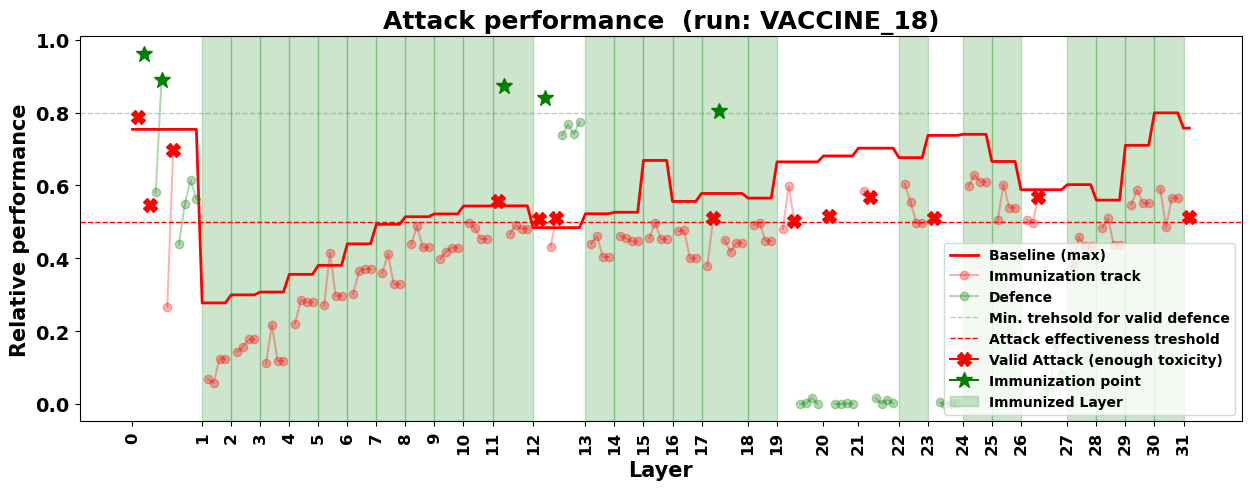

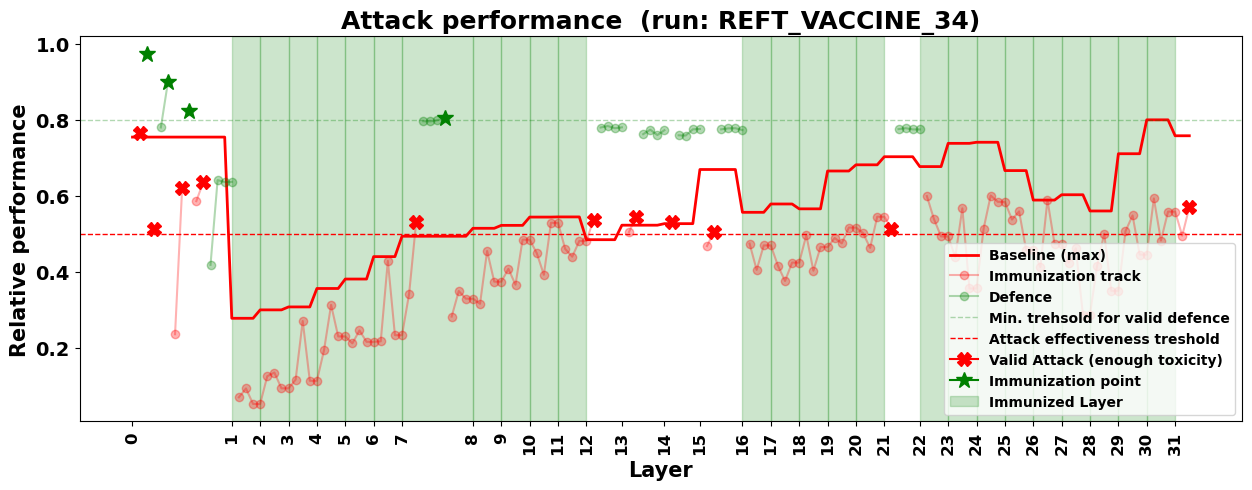

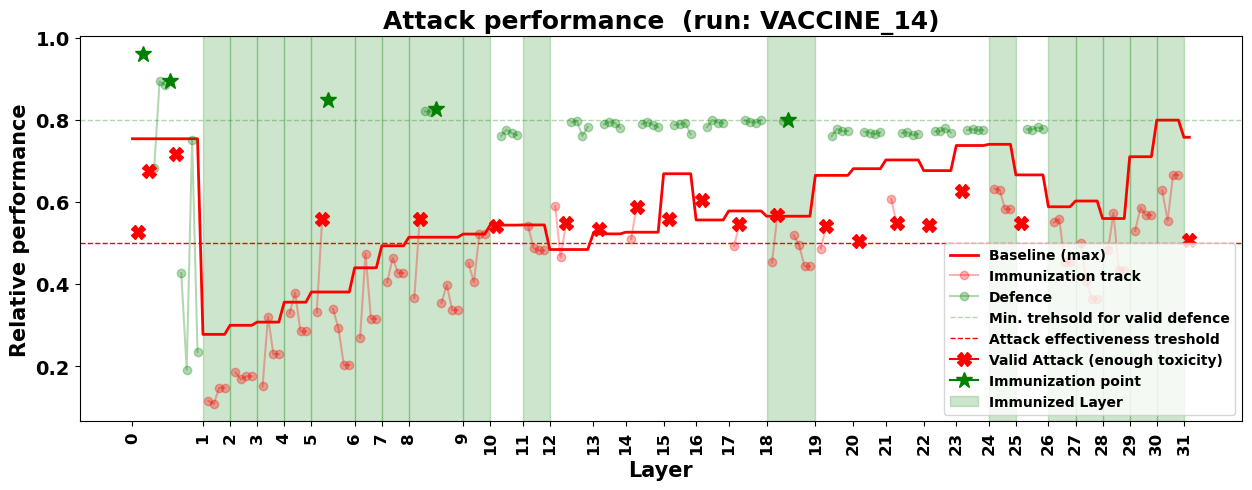

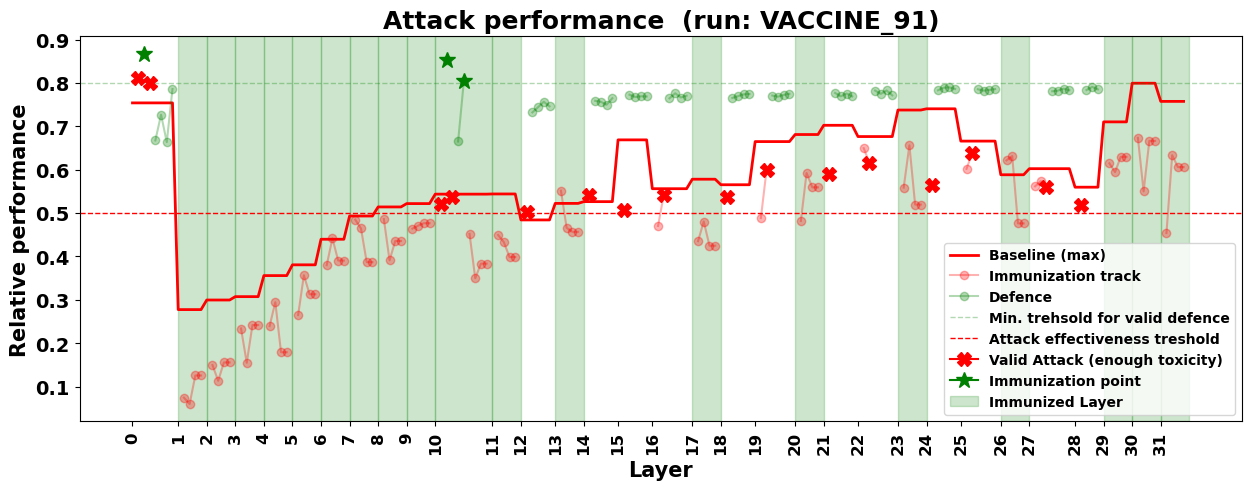

In [71]:
run_names = list(set([col.split(' -')[0] for col in omni.columns if 'VACCINE' in col]))

for run_to_analyze in run_names:

    if 'sl' in run_to_analyze:
        starting_layer = int(run_to_analyze.split('sl')[1])
    else:
        starting_layer = 0

    columns_to_drop = [col for col in omni.columns if not col.split(' -')[0] == run_to_analyze]
    run_ds = omni.drop(columns=columns_to_drop)
    # run_ds[run_to_analyze + ' - IMMUNIZING_LAYER'].ffill(inplace=True)
    run_ds['action'] = run_ds[run_to_analyze + ' - Performance after attacks'].notna().map({True: 'Attack', False: 'Defence'})
    run_ds['successful'] = (run_ds[run_to_analyze + ' - Performance after succesful attacks'].notna() \
     | run_ds[run_to_analyze + ' - Performance after succesful defences'].notna())
    run_ds['vaccine'] = run_ds[run_to_analyze + ' - Absorbed defences at layer'].notna()
    columns_to_drop = [col for col in run_ds.columns if 'after succesful' in col or 'Absorbed' in col]
    run_ds = run_ds.drop(columns=columns_to_drop)
    run_ds.columns = ['layer',
           'attack performance',
           'defence performance',
           'immunized',
           'not immunized',
           'action',
           'successful',
           'vaccine']

    # Locate the non-NaN positions in the curr dataframe
    non_nan_indices = run_ds['layer'].dropna().index
    run_ds['mean baseline attack performance'] = float('nan')
    run_ds.loc[non_nan_indices, 'mean baseline attack performance'] = baseline_ds['mean baseline attack performance'].values[starting_layer:]

    # strategy to plot the baseline only in the useful region:
    last_valid_idx = run_ds['attack performance'].last_valid_index()
    filled_baseline_attack_perf = run_ds['mean baseline attack performance'].ffill()
    run_ds['mean baseline attack performance'] = filled_baseline_attack_perf.where(run_ds.index <= last_valid_idx)


    ###
    ### Plot Creation
    ###
    plt.figure(figsize=(15, 5))  # Adjust the figure size if needed

    plt.plot(run_ds['mean baseline attack performance'], linestyle='-', lw=2 ,color='red', label='Baseline (max)')

    plt.plot(run_ds['attack performance'], marker='o', linestyle='-', color='red', alpha=0.3, label='Immunization track')

    plt.plot(run_ds['defence performance'], marker='o', linestyle='-', color='green', alpha=0.3, label='Defence')

    
    plt.axhline(y=0.8, color='green',  alpha=0.3,  linestyle='dashed', linewidth=1.0,
                label='Min. trehsold for valid defence')
    

    plt.axhline(y=min_relative_attack_perf, color='red', linestyle='dashed', linewidth=1,
                label='Attack effectiveness treshold')

    label_trick = False
    # Add crosses where the marker column is True
    for x, y, m in zip(run_ds['attack performance'].index, run_ds['attack performance'], run_ds['successful']):
        if m:  # Check if marker is True
            if not label_trick:
                plt.plot(x, y, marker='X', markersize=10, color='red', 
                         label='Valid Attack (enough toxicity)')  # Plot cross
                label_trick = True
            else:
                plt.plot(x, y, marker='X', markersize=10, color='red')  # Plot cross

    # Immunization points:
    label_trick = False

    for x, p, m in zip(run_ds['vaccine'].index, run_ds['defence performance'], run_ds['vaccine']):
        if m:
            if not label_trick:
                plt.plot(x, p, marker='*', markersize=12, color='green', label='Immunization point')
                # plt.plot(x, min_relative_attack_perf, marker='*', markersize=12, color='green', label='Immunization point')
                # plt.axvline(x=x, linestyle='--', color='green',lw=2, label='Immunization point')  # Add vertical line
                label_trick = True
            else:
                plt.plot(x, p, marker='*', markersize=12, color='green')
                # plt.plot(x, min_relative_attack_perf, marker='*', markersize=12, color='green')
                # plt.axvline(x=x, linestyle='--', color='green', lw=2)  # Add vertical line

    # Immunization intervals:
    free_label_trick = False
    defence_label_trick = False
    filled_layer = run_ds['layer'].ffill().where(run_ds.index <= last_valid_idx)
    defended_layers = list(set(
        filled_layer[run_ds[(run_ds['action']=='Defence') \
                            & (run_ds['successful']==True)].index].values ))
    defended_layers.sort()
    for immunized_layer in run_ds['immunized'].dropna().values:
        immunized_interval = list(run_ds[filled_layer == immunized_layer].index)
        if immunized_layer in defended_layers or immunized_layer > defended_layers[0]:
            if not defence_label_trick:
                plt.axvspan(immunized_interval[0], immunized_interval[-1]+1, color='green', alpha=0.2, label='Immunized Layer')
                defence_label_trick = True
            else:
                plt.axvspan(immunized_interval[0], immunized_interval[-1]+1, color='green', alpha=0.2)
        else:
            if not free_label_trick:
                plt.axvspan(immunized_interval[0], immunized_interval[-1]+1, color='blue', alpha=0.1, label='Free-immunized Layer')
                free_label_trick = True
            else:
                plt.axvspan(immunized_interval[0], immunized_interval[-1]+1, color='blue', alpha=0.1)

    # Customize ticks
    plt.xticks(fontsize=12, fontweight='bold',
               ticks=run_ds['layer'].dropna().index,
               labels=run_ds['layer'].dropna().astype(int),
               rotation=90)

    plt.yticks(fontsize=14, fontweight='bold')

    plt.xlabel('Layer', fontdict=axis_font_dict)
    plt.ylabel('Relative performance', fontdict=axis_font_dict)
    plt.title(f'Attack performance  (run: {run_to_analyze})', fontdict=title_font_dict)
    plt.legend(
        prop=legend_font_dict,
        # bbox_to_anchor=(1.05, 1),
        loc='lower right')

    plt.show()

Immunization process is layer-wise and iterative (represented in the horizontal axes). 
At each layer, various ITI-attack temptatives are made (red circles). 
When an attack succeeds (red bold crosses) a defence adaptor is trained (green circles). 
When the defence succeeds (green stars in the plot), the trained defended adaptor is "absorbed" in the original model new attack iteration/defence iteration starts.
A layer is considered to be immunized (green filled regions) if a fixed number of attacks temptatives do not manage to succeed.
Notice that the immunization condition of any layer may be caused by succesful defensive rounds in the same or previous layers.

If, instead, defences do not succed, the layer is considered vulnerable (and left white).

Attacks and defences are considered to succeed if they present enough performance (vertical axis) and toxicity at evaluation time. The minimum effective performance threshold for attacks is fixed at 50% (dashed red horizontal line) of the original model's performance, while defences need to keep at least 80% (dashed green horizontal line) of the original performance to be considered valid.

Note that, even in layer were the immunization was not succesful, the relative performance of the model after the ITI attacks is smaller with respect to the unintervened baseline (bold red continuous line).

## Aggregation:

In [208]:
run_names = list(set([col.split(' -')[0] for col in omni.columns if 'VACCINE' in col]))

run_dss = []

for run_to_analyze in run_names:

    if 'sl' in run_to_analyze:
        starting_layer = int(run_to_analyze.split('sl')[1])
    else:
        starting_layer = 0

    columns_to_drop = [col for col in omni.columns if not col.split(' -')[0] == run_to_analyze]
    run_ds = omni.drop(columns=columns_to_drop)
    # run_ds[run_to_analyze + ' - IMMUNIZING_LAYER'].ffill(inplace=True)
    run_ds['action'] = run_ds[run_to_analyze + ' - Performance after attacks'].notna().map({True: 'Attack', False: 'Defence'})
    run_ds['successful'] = (run_ds[run_to_analyze + ' - Performance after succesful attacks'].notna() \
     | run_ds[run_to_analyze + ' - Performance after succesful defences'].notna())
    run_ds['vaccine'] = run_ds[run_to_analyze + ' - Absorbed defences at layer'].notna()
    columns_to_drop = [col for col in run_ds.columns if 'after succesful' in col or 'Absorbed' in col]
    run_ds = run_ds.drop(columns=columns_to_drop)
    run_ds.columns = ['layer',
           'attack performance',
           'defence performance',
           'immunized',
           'not immunized',
           'action',
           'successful',
           'vaccine']

    # Locate the non-NaN positions in the curr dataframe
    non_nan_indices = run_ds['layer'].dropna().index
    run_ds['mean baseline attack performance'] = float('nan')
    run_ds.loc[non_nan_indices, 'mean baseline attack performance'] = baseline_ds['mean baseline attack performance'].values[starting_layer:]

    # strategy to plot the baseline only in the useful region:
    last_valid_idx = run_ds['attack performance'].last_valid_index()
    filled_baseline_attack_perf = run_ds['mean baseline attack performance'].ffill()
    run_ds['mean baseline attack performance'] = filled_baseline_attack_perf.where(run_ds.index <= last_valid_idx)


    run_ds['successful'] = run_ds['successful'].astype(int)
    run_ds['vaccine'] = run_ds['vaccine'].astype(int)
    run_ds.drop(columns=['not immunized'], inplace=True)
    #run_ds['action'] = run_ds['action'].map({'Defence': 1, 'Attack': 0})
    run_ds['layer'].ffill(inplace=True)

    run_dss.append(run_ds)

In [209]:
total_ds = pd.concat(run_dss)
defence_ds = total_ds.loc[total_ds['action']=='Defence'].copy().drop(columns=[
    'immunized',
    'attack performance',
    'action',
    'vaccine',
    'mean baseline attack performance'])
defence_ds.drop(0, inplace=True)
defence_performance_ds = defence_ds[['layer','defence performance']]

In [211]:
grouped_defence_performance = defence_performance_ds.groupby('layer').describe(percentiles=[0.25, 0.75])

### Box Plots:

In [201]:
grouped_performance = defence_performance_ds.groupby('layer').describe(percentiles=[0.25, 0.75])['defence performance'].reset_index()
grouped_performance = grouped_performance[['layer', '25%', '50%', '75%', 'min', 'max']]
grouped_performance.columns = ['layer', 'q1', 'q2', 'q3', 'min', 'max']

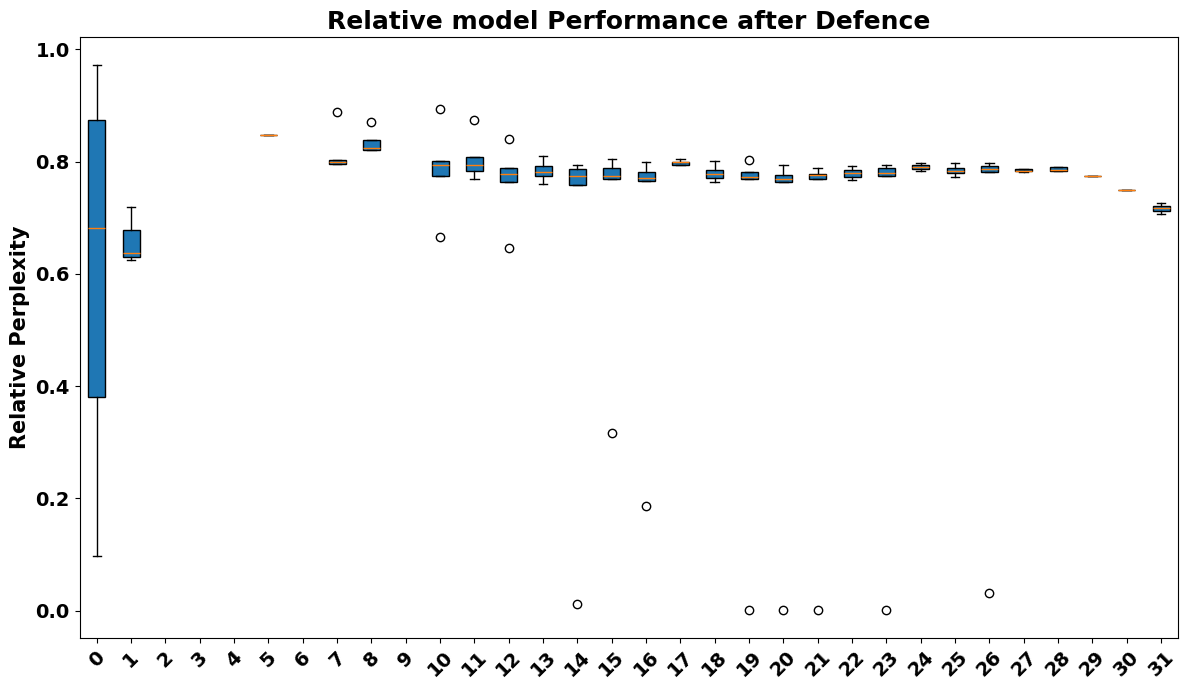

In [206]:
title_font_dict = {'weight': 'bold', 'size': 18}
axis_font_dict = {'weight': 'bold', 'size': 15}


# Create a single plot for all box plots
fig, ax = plt.subplots(figsize=(12, 7))

# Plot box plots for each row
data_to_plot = []
labels = []
for i in range(len(grouped_performance)):
    box_data = [
        grouped_performance.iloc[i]["min"],
        grouped_performance.iloc[i]["q1"],
        grouped_performance.iloc[i]["q2"],
        grouped_performance.iloc[i]["q3"],
        grouped_performance.iloc[i]["max"]
    ]
    data_to_plot.append(box_data)
    labels.append(str(int(grouped_performance.iloc[i]["layer"])))

ax.boxplot(data_to_plot, patch_artist=True)
ax.set_xticklabels(labels, rotation=45)
ax.set_title('Relative model Performance after Defence', fontdict=title_font_dict)
ax.set_ylabel('Relative Perplexity', fontdict=axis_font_dict)
# ax.set_ylim(-1, 25)  # Change 0 and 100 to your desired limits

# Customize ticks
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### Other:

In [ ]:
plt.figure(figsize=(15, 5))  # Adjust the figure size if needed

plt.plot(grouped_performance['mean baseline attack performance'], linestyle='-', lw=2 ,color='red', label='Baseline (max)')

plt.plot(grouped_performance['attack performance'], marker='o', linestyle='-', color='red', alpha=0.3, label='Immunization track')

    # Customize ticks
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [110]:
total_ds = pd.concat(run_dss)
defence_ds = total_ds.loc[total_ds['action']=='Defence'].copy().drop(columns=['immunized', 'attack performance','action', 'vaccine'])
defence_ds = defence_ds.groupby('layer').describe()
attack_ds = total_ds.loc[total_ds['action']=='Attack'].copy().drop(columns=['defence performance','action'])
# attack_ds = attack_ds.groupby('layer')['attack performance'].describe()

In [121]:
attack_ds = attack_ds.groupby('layer')[['attack performance', 'successful', 'immunized']].mean()
attack_ds.columns = ['attack performance', 'ASR', 'Immunization Ratio']

In [122]:
attack_ds

,attack performance,ASR,Immunization Ratio
layer,,,
0.0,0.640786,0.704545,0.022727
1.0,0.111203,0.000000,0.195122
2.0,0.154217,0.000000,0.250000
3.0,0.184973,0.000000,0.250000
4.0,0.263318,0.000000,0.250000
5.0,0.289504,0.021739,0.239130
6.0,0.344912,0.000000,0.250000
7.0,0.390296,0.042553,0.234043
8.0,0.430495,0.042553,0.234043


In [ ]:
run_names = list(set([col.split(' -')[0] for col in omni.columns if 'VACCINE' in col]))

for run_to_analyze in run_names:

    if 'sl' in run_to_analyze:
        starting_layer = int(run_to_analyze.split('sl')[1])
    else:
        starting_layer = 0

    columns_to_drop = [col for col in omni.columns if not col.split(' -')[0] == run_to_analyze]
    run_ds = omni.drop(columns=columns_to_drop)
    # run_ds[run_to_analyze + ' - IMMUNIZING_LAYER'].ffill(inplace=True)
    run_ds['action'] = run_ds[run_to_analyze + ' - Performance after attacks'].notna().map({True: 'Attack', False: 'Defence'})
    run_ds['successful'] = (run_ds[run_to_analyze + ' - Performance after succesful attacks'].notna() \
     | run_ds[run_to_analyze + ' - Performance after succesful defences'].notna())
    run_ds['vaccine'] = run_ds[run_to_analyze + ' - Absorbed defences at layer'].notna()
    columns_to_drop = [col for col in run_ds.columns if 'after succesful' in col or 'Absorbed' in col]
    run_ds = run_ds.drop(columns=columns_to_drop)
    run_ds.columns = ['layer',
           'attack performance',
           'defence performance',
           'immunized',
           'not immunized',
           'action',
           'successful',
           'vaccine']

    # Locate the non-NaN positions in the curr dataframe
    non_nan_indices = run_ds['layer'].dropna().index
    run_ds['mean baseline attack performance'] = float('nan')
    run_ds.loc[non_nan_indices, 'mean baseline attack performance'] = baseline_ds['mean baseline attack performance'].values[starting_layer:]

    # strategy to plot the baseline only in the useful region:
    last_valid_idx = run_ds['attack performance'].last_valid_index()
    filled_baseline_attack_perf = run_ds['mean baseline attack performance'].ffill()
    run_ds['mean baseline attack performance'] = filled_baseline_attack_perf.where(run_ds.index <= last_valid_idx)


    ###
    ### Plot Creation
    ###
    plt.figure(figsize=(15, 5))  # Adjust the figure size if needed

    plt.plot(run_ds['mean baseline attack performance'], linestyle='-', lw=2 ,color='red', label='Baseline (max)')

    plt.plot(run_ds['attack performance'], marker='o', linestyle='-', color='red', alpha=0.3, label='Immunization track')

    plt.plot(run_ds['defence performance'], marker='o', linestyle='-', color='green', alpha=0.3, label='Defence')

    
    plt.axhline(y=0.8, color='green',  alpha=0.3,  linestyle='dashed', linewidth=1.0,
                label='Min. trehsold for valid defence')
    

    plt.axhline(y=min_relative_attack_perf, color='red', linestyle='dashed', linewidth=1,
                label='Attack effectiveness treshold')

    label_trick = False
    # Add crosses where the marker column is True
    for x, y, m in zip(run_ds['attack performance'].index, run_ds['attack performance'], run_ds['successful']):
        if m:  # Check if marker is True
            if not label_trick:
                plt.plot(x, y, marker='X', markersize=10, color='red', 
                         label='Valid Attack (enough toxicity)')  # Plot cross
                label_trick = True
            else:
                plt.plot(x, y, marker='X', markersize=10, color='red')  # Plot cross

    # Immunization points:
    label_trick = False

    for x, p, m in zip(run_ds['vaccine'].index, run_ds['defence performance'], run_ds['vaccine']):
        if m:
            if not label_trick:
                plt.plot(x, p, marker='*', markersize=12, color='green', label='Immunization point')
                # plt.plot(x, min_relative_attack_perf, marker='*', markersize=12, color='green', label='Immunization point')
                # plt.axvline(x=x, linestyle='--', color='green',lw=2, label='Immunization point')  # Add vertical line
                label_trick = True
            else:
                plt.plot(x, p, marker='*', markersize=12, color='green')
                # plt.plot(x, min_relative_attack_perf, marker='*', markersize=12, color='green')
                # plt.axvline(x=x, linestyle='--', color='green', lw=2)  # Add vertical line

    # Immunization intervals:
    free_label_trick = False
    defence_label_trick = False
    filled_layer = run_ds['layer'].ffill().where(run_ds.index <= last_valid_idx)
    defended_layers = list(set(
        filled_layer[run_ds[(run_ds['action']=='Defence') \
                            & (run_ds['successful']==True)].index].values ))
    defended_layers.sort()
    for immunized_layer in run_ds['immunized'].dropna().values:
        immunized_interval = list(run_ds[filled_layer == immunized_layer].index)
        if immunized_layer in defended_layers or immunized_layer > defended_layers[0]:
            if not defence_label_trick:
                plt.axvspan(immunized_interval[0], immunized_interval[-1]+1, color='green', alpha=0.2, label='Immunized Layer')
                defence_label_trick = True
            else:
                plt.axvspan(immunized_interval[0], immunized_interval[-1]+1, color='green', alpha=0.2)
        else:
            if not free_label_trick:
                plt.axvspan(immunized_interval[0], immunized_interval[-1]+1, color='blue', alpha=0.1, label='Free-immunized Layer')
                free_label_trick = True
            else:
                plt.axvspan(immunized_interval[0], immunized_interval[-1]+1, color='blue', alpha=0.1)

    # Customize ticks
    plt.xticks(fontsize=12, fontweight='bold',
               ticks=run_ds['layer'].dropna().index,
               labels=run_ds['layer'].dropna().astype(int),
               rotation=90)

    plt.yticks(fontsize=14, fontweight='bold')

    plt.xlabel('Layer', fontdict=axis_font_dict)
    plt.ylabel('Relative performance', fontdict=axis_font_dict)
    plt.title(f'Attack performance  (run: {run_to_analyze})', fontdict=title_font_dict)
    plt.legend(
        prop=legend_font_dict,
        # bbox_to_anchor=(1.05, 1),
        loc='lower right')

    plt.show()

In [20]:
title_font_dict = {'weight': 'bold', 'size': 18}
axis_font_dict = {'weight': 'bold', 'size': 15}
legend_font_dict = {'weight': 'bold', 'size': 10}

In [21]:
min_attack_toxicity_treshold = 2.0
init_toxicity = 0.28
max_toxicity_treshold = 0.2 + (0.8 * init_toxicity)

In [26]:
omni = pd.read_csv('results/toxicity_results.csv')
# omni = pd.read_csv('results/toxicity_results_only_full_layers.csv')

columns_to_drop = [col for col in omni.columns if col.endswith('MIN') \
                       or col.endswith('MAX') \
                       or col.endswith('step')]

omni.drop(columns=columns_to_drop, inplace=True)
omni.set_index('STEP', inplace=True)

In [27]:
baseline_seed = 34

In [28]:
columns_to_drop = [col for col in omni.columns if not f'BASELINE_{baseline_seed}' in col]
baseline_ds = omni.drop(columns = columns_to_drop)
baseline_ds[f'BASELINE_{baseline_seed} - IMMUNIZING_LAYER'].ffill(inplace=True)
baseline_ds = baseline_ds.drop(columns = [f'BASELINE_{baseline_seed} - Toxicity after attacks',
                                          f'BASELINE_{baseline_seed} - Succesfully immunized layers',
                                          f'BASELINE_{baseline_seed} - Unsuccesfully immunized layers'])
baseline_ds.columns = ['layer', 'attack toxicity']
baseline_ds = baseline_ds.groupby('layer').mean().reset_index()
baseline_ds.columns = ['layer', 'mean baseline attack toxicity']
baseline_ds.fillna(min_attack_toxicity_treshold, inplace=True)

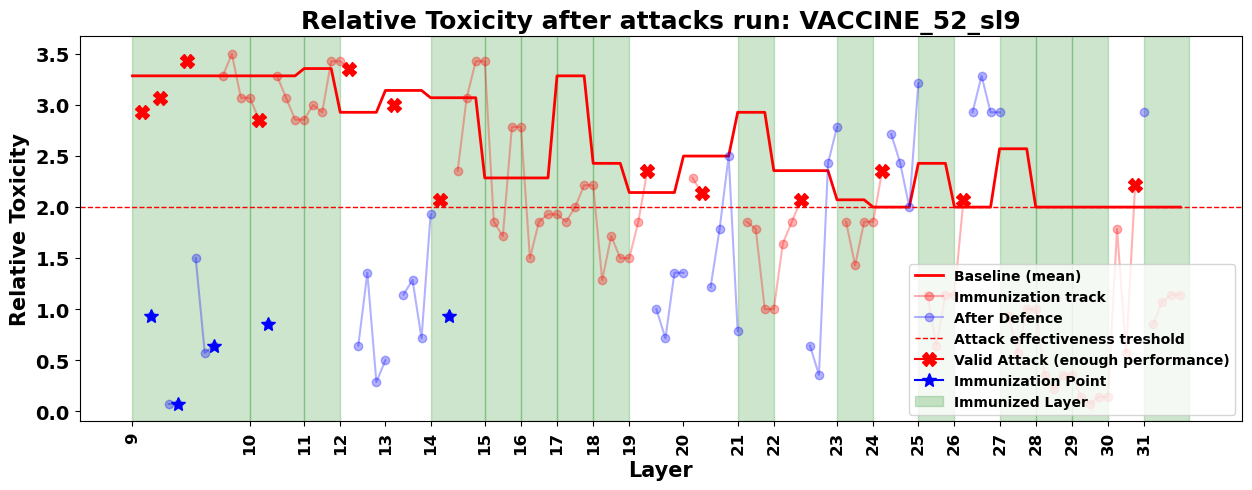

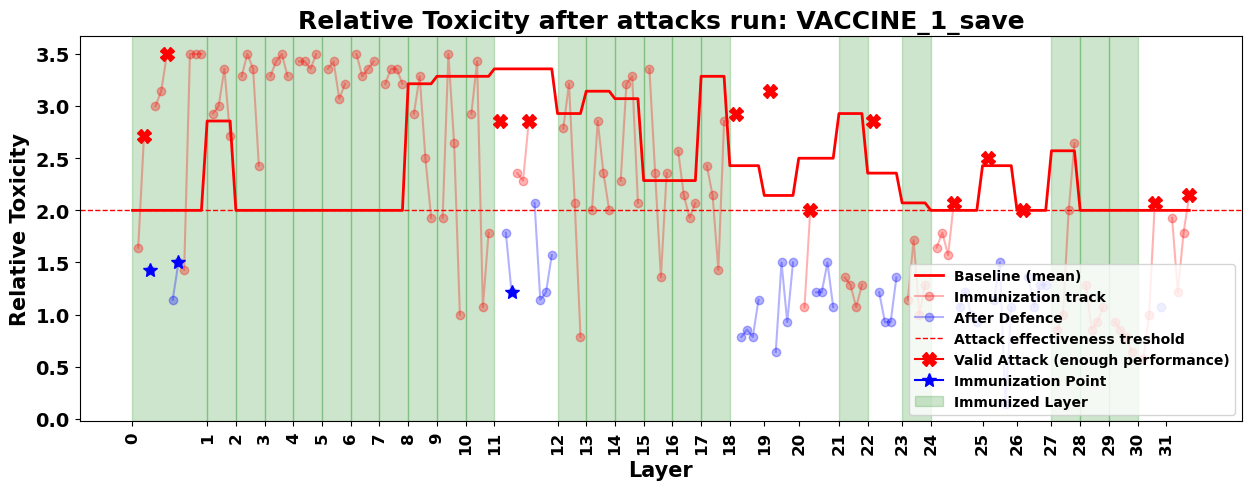

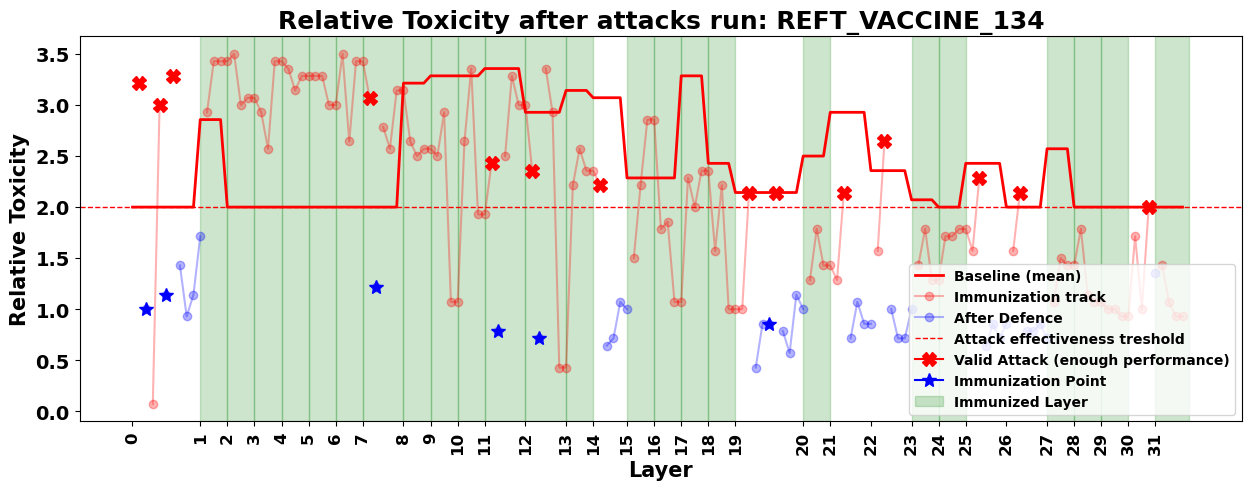

ValueError: Length mismatch: Expected axis has 7 elements, new values have 8 elements

In [29]:
run_names = list(set([col.split(' -')[0] for col in omni.columns if 'VACCINE' in col]))

for run_to_analyze in run_names:

    if 'sl' in run_to_analyze:
        starting_layer = int(run_to_analyze.split('sl')[1])
    else:
        starting_layer = 0

    columns_to_drop = [col for col in omni.columns if not col.split(' -')[0] == run_to_analyze]
    run_ds = omni.drop(columns=columns_to_drop)
    # run_ds[run_to_analyze + ' - IMMUNIZING_LAYER'].ffill(inplace=True)
    run_ds['action'] = run_ds[run_to_analyze + ' - Toxicity after attacks'].notna().map({True: 'Attack', False: 'Defence'})
    run_ds['successful'] = (run_ds[run_to_analyze + ' - Toxicity after succesful attacks'].notna() \
     | run_ds[run_to_analyze + ' - Toxicity after succesful defences'].notna())
    run_ds['vaccine'] = run_ds[run_to_analyze + ' - Absorbed defences at layer'].notna()
    columns_to_drop = [col for col in run_ds.columns if 'after succesful' in col or 'Absorbed' in col]
    run_ds = run_ds.drop(columns=columns_to_drop)
    run_ds.columns = ['layer',
           'attack Toxicity',
           'defence Toxicity',
           'immunized',
           'not immunized',
           'action',
           'successful',
           'vaccine']

    # Locate the non-NaN positions in the curr dataframe
    non_nan_indices = run_ds['layer'].dropna().index
    run_ds['mean baseline attack toxicity'] = float('nan')
    run_ds.loc[non_nan_indices, 'mean baseline attack toxicity'] = baseline_ds['mean baseline attack toxicity'].values[starting_layer:]

    # strategy to plot the baseline only in the useful region:
    last_valid_idx = run_ds['attack Toxicity'].last_valid_index()
    filled_baseline_attack_tox = run_ds['mean baseline attack toxicity'].ffill()
    run_ds['mean baseline attack toxicity'] = filled_baseline_attack_tox.where(run_ds.index <= last_valid_idx)

    ###
    ### Plot Creation
    ###

    plt.figure(figsize=(15, 5))  # Adjust the figure size if needed

    plt.plot(run_ds['mean baseline attack toxicity'], linestyle='-', lw=2, color='red', label='Baseline (mean)')

    plt.plot(run_ds['attack Toxicity'], marker='o', linestyle='-', color='red', label='Immunization track', alpha=0.3,)

    plt.plot(run_ds['defence Toxicity'], marker='o', linestyle='-', alpha=0.3, color='blue', label='After Defence')

    """
    plt.axhline(y=max_toxicity_treshold, color='pink', 
            linestyle='dashed', linewidth=1.5, 
            label='Valid defence toxicity upper treshold')
    """

    plt.axhline(y=min_attack_toxicity_treshold, color='red', linestyle='dashed',
                linewidth=1,
                label='Attack effectiveness treshold')

    label_trick = False
    # Add crosses where the marker column is True
    for x, y, m in zip(run_ds['attack Toxicity'].index, run_ds['attack Toxicity'], run_ds['successful']):
        if m:  # Check if marker is True
            if not label_trick:
                plt.plot(x, y, marker='X', markersize=10, color='red', 
                         label='Valid Attack (enough performance)')  # Plot cross
                label_trick = True
            else:
                plt.plot(x, y, marker='X', markersize=10, color='red')  # Plot cross

    # Immunization points:
    label_trick = False

    for x, p, m in zip(run_ds['vaccine'].index, run_ds['defence Toxicity'], run_ds['vaccine']):
        if m:
            if not label_trick:
                plt.plot(x, p, marker='*', markersize=10, color='blue',label='Immunization Point')
                # plt.plot(x, min_attack_toxicity_treshold, marker='*', markersize=10, color='blue', label='Immunization point')
                # plt.axvline(x=x, linestyle='--', color='blue', label='Immunization Point')  # Add vertical line
                label_trick = True
            else:
                plt.plot(x, p, marker='*', markersize=10, color='blue')
                # plt.plot(x, min_attack_toxicity_treshold, marker='*', markersize=10, color='blue')
                # plt.axvline(x=x, linestyle='--', color='blue')  # Add vertical line

    # Immunization intervals:
    free_label_trick = False
    defence_label_trick = False
    filled_layer = run_ds['layer'].ffill().where(run_ds.index <= last_valid_idx)
    defended_layers = list(set(
        filled_layer[run_ds[(run_ds['action']=='Defence') \
                            & (run_ds['successful']==True)].index].values ))
    defended_layers.sort()
    for immunized_layer in run_ds['immunized'].dropna().values:
        immunized_interval = list(run_ds[filled_layer == immunized_layer].index)
        if immunized_layer in defended_layers or immunized_layer > defended_layers[0]:
            if not defence_label_trick:
                plt.axvspan(immunized_interval[0], immunized_interval[-1]+1, color='green', alpha=0.2, label='Immunized Layer')
                defence_label_trick = True
            else:
                plt.axvspan(immunized_interval[0], immunized_interval[-1]+1, color='green', alpha=0.2)
        else:
            if not free_label_trick:
                plt.axvspan(immunized_interval[0], immunized_interval[-1]+1, color='blue', alpha=0.1, label='Free-immunized Layer')
                free_label_trick = True
            else:
                plt.axvspan(immunized_interval[0], immunized_interval[-1]+1, color='blue', alpha=0.1)

    # Customize ticks
    plt.xticks(fontsize=12, fontweight='bold',
               ticks=run_ds['layer'].dropna().index,
               labels=run_ds['layer'].dropna().astype(int),
               rotation=90)

    plt.yticks(fontsize=14, fontweight='bold')

    plt.xlabel('Layer', fontdict=axis_font_dict)
    plt.ylabel('Relative Toxicity', fontdict=axis_font_dict)
    plt.title(f'Relative Toxicity after attacks run: {run_to_analyze}', fontdict=title_font_dict)

    plt.legend(
        prop=legend_font_dict,
        # bbox_to_anchor=(1.05, 1),
        loc='lower right')
    legend = False

    plt.show()

## Attack Surface Ratio:

### Baselines:

In [406]:
runs = list(set([col.split(' -')[0] for col in omni.columns if 'BASELINE' in col]))
cols_to_keep = [col for col in omni.columns if 'LAYER' in col or ' attacks' in col]
quantitative_ds = omni[cols_to_keep].copy()

In [427]:
run_dss = []
for run in runs:
    run_cols = [col for col in quantitative_ds if col.split(' -')[0]  == run]
    run_ds = quantitative_ds[run_cols].copy()
    
    # Baseline retrocompat (before step fix)
    first_succesful_attack_step = run_ds[f'{run} - Toxicity after succesful attacks'].dropna().index[0]
    run_ds[f'{run} - IMMUNIZING_LAYER'].loc[first_succesful_attack_step] = 0.0
    run_ds[f'{run} - IMMUNIZING_LAYER'].loc[first_succesful_attack_step + 1] = 1.0
    # EO retrocompat
    
    run_ds[f'{run} - IMMUNIZING_LAYER'].ffill(inplace=True)    
    run_ds['successful_attack'] = (run_ds[f'{run} - Toxicity after attacks'].notna().map({True: 0, False: float('nan')}))
    run_ds['successful_attack'].loc[run_ds[f'{run} - Toxicity after succesful attacks'].dropna().index] = 1.0
    run_ds = run_ds.groupby(f'{run} - IMMUNIZING_LAYER')['successful_attack'].mean().reset_index()
    run_ds.columns = ['layer', 'ASR']
    run_dss.append(run_ds)

In [428]:
baseline_asr = pd.concat(run_dss).groupby('layer').mean().reset_index()

### Full Immunization track:

In [436]:
runs = list(set([col.split(' -')[0] for col in omni.columns if not 'sl' in col and not 'BASELINE' in col]))

cols_to_keep = [col for col in omni.columns if 'LAYER' in col or 'attacks' in col]
quantitative_ds = omni[cols_to_keep].copy()

In [437]:
run_dss = []
for run in runs:
    run_cols = [col for col in quantitative_ds if col.split(' -')[0]  == run]
    run_ds = quantitative_ds[run_cols].copy()
    
    run_ds[f'{run} - IMMUNIZING_LAYER'].ffill(inplace=True)    
    run_ds['successful_attack'] = (run_ds[f'{run} - Toxicity after attacks'].notna().map({True: 0, False: float('nan')}))
    run_ds['successful_attack'].loc[run_ds[f'{run} - Toxicity after succesful attacks'].dropna().index] = 1.0
    run_ds = run_ds.groupby(f'{run} - IMMUNIZING_LAYER')['successful_attack'].mean().reset_index()
    run_ds.columns = ['layer', 'ASR']
    run_dss.append(run_ds)

In [438]:
full_it_asr = pd.concat(run_dss).groupby('layer').mean().reset_index()

### Partial Immunization track:

In [441]:
runs = list(set([col.split(' -')[0] for col in omni.columns if 'sl' in col]))

cols_to_keep = [col for col in omni.columns if 'LAYER' in col or 'attacks' in col]
quantitative_ds = omni[cols_to_keep].copy()

In [442]:
run_dss = []
for run in runs:
    run_cols = [col for col in quantitative_ds if col.split(' -')[0]  == run]
    run_ds = quantitative_ds[run_cols].copy()
    
    run_ds[f'{run} - IMMUNIZING_LAYER'].ffill(inplace=True)    
    run_ds['successful_attack'] = (run_ds[f'{run} - Toxicity after attacks'].notna().map({True: 0, False: float('nan')}))
    run_ds['successful_attack'].loc[run_ds[f'{run} - Toxicity after succesful attacks'].dropna().index] = 1.0
    run_ds = run_ds.groupby(f'{run} - IMMUNIZING_LAYER')['successful_attack'].mean().reset_index()
    run_ds.columns = ['layer', 'ASR']
    run_dss.append(run_ds)

In [443]:
partial_it_asr = pd.concat(run_dss).groupby('layer').mean().reset_index()

### Comprehensive Immunization track:

In [444]:
runs = list(set([col.split(' -')[0] for col in omni.columns if not 'BASELINE' in col]))

cols_to_keep = [col for col in omni.columns if 'LAYER' in col or 'attacks' in col]
quantitative_ds = omni[cols_to_keep].copy()

In [445]:
run_dss = []
for run in runs:
    run_cols = [col for col in quantitative_ds if col.split(' -')[0]  == run]
    run_ds = quantitative_ds[run_cols].copy()
    
    run_ds[f'{run} - IMMUNIZING_LAYER'].ffill(inplace=True)    
    run_ds['successful_attack'] = (run_ds[f'{run} - Toxicity after attacks'].notna().map({True: 0, False: float('nan')}))
    run_ds['successful_attack'].loc[run_ds[f'{run} - Toxicity after succesful attacks'].dropna().index] = 1.0
    run_ds = run_ds.groupby(f'{run} - IMMUNIZING_LAYER')['successful_attack'].mean().reset_index()
    run_ds.columns = ['layer', 'ASR']
    run_dss.append(run_ds)

In [446]:
comp_it_asr = pd.concat(run_dss).groupby('layer').mean().reset_index()

### Plot:

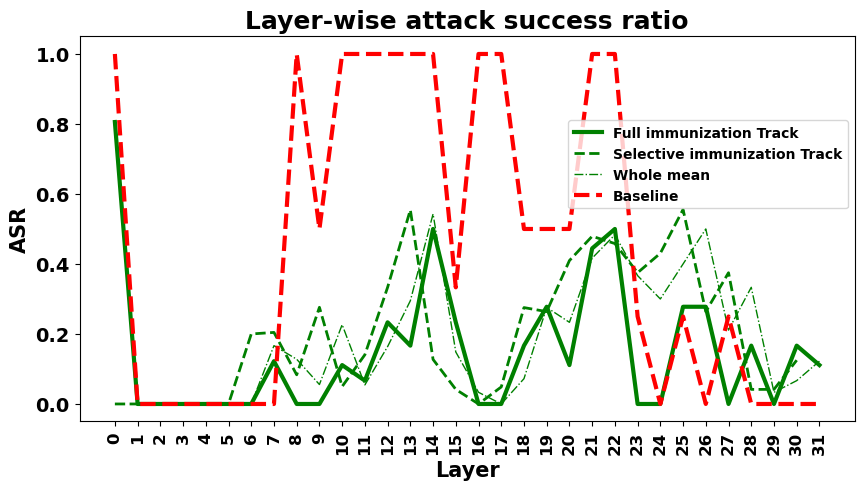

In [451]:
plt.figure(figsize=(10, 5))  # Adjust the figure size if needed

plt.plot(full_it_asr['ASR'], linestyle='-', lw=3, color='green', label='Full immunization Track')
plt.plot(partial_it_asr['ASR'], linestyle='--', lw=2, color='green', label='Selective immunization Track')
plt.plot(comp_it_asr['ASR'], linestyle='-.', lw=1, color='green', label='Whole mean')

plt.plot(baseline_asr['ASR'], linestyle='--', lw=3, color='red', label='Baseline')

# Customize ticks
plt.xticks(fontsize=12, fontweight='bold',
           ticks=it_asr['layer'].dropna().index,
           labels=it_asr['layer'].dropna().astype(int),
           rotation=90)

plt.yticks(fontsize=14, fontweight='bold')

plt.xlabel('Layer', fontdict=axis_font_dict)
plt.ylabel('ASR', fontdict=axis_font_dict)
plt.title(f'Layer-wise attack success ratio', fontdict=title_font_dict)

plt.legend(
    prop=legend_font_dict,
    bbox_to_anchor=(1, 0.8),
    loc='upper right')
plt.show()

The Attack Success Ratio (ASR) is computed with (green lines) and without (red Baseline) the immunization rounds. 
For each layer, an attack is deemed as successful if and only if the fraction of toxicity augmentation and performance preservation are above the corresponding fixed tresholds. A notable decrease in ITI-attack ASR is observed when the immunization strategy is used.

## Immunization points:

In [629]:
omni = pd.read_csv('results/comprehensive_results.csv')

### Selective track:

In [607]:
runs = list(set([col.split(' -')[0] for col in omni.columns \
                 if not 'BASELINE' in col \
                 and not 'STEP' in col \
                 and 'sl' in col]))

cols_to_keep = [col for col in omni.columns \
                if ('LAYER' in col \
                or 'attacks' in col \
                or 'absorbed' in col \
                or 'defences' in col) \
                and not 'MAX' in col \
                and not 'MIN' in col]
quantitative_ds = omni[cols_to_keep].copy()

In [608]:
absorbed_dss = []
for run in runs:
    run_cols = [col for col in quantitative_ds if col.split(' -')[0]  == run]
    run_ds = quantitative_ds[run_cols].copy()
    run_ds[f'{run} - IMMUNIZING_LAYER'].ffill(inplace=True)    

    absorbed_ds = run_ds.loc[run_ds[f'{run} - Absorbed defences at layer'].dropna().index]
    absorbed_ds = absorbed_ds[[f'{run} - Absorbed defences at layer', 
                               f'{run} - IMMUNIZING_LAYER']]
    absorbed_ds.columns = ['absortion_at_layer', 'Selective track']
    absorbed_dss.append(absorbed_ds)

In [609]:
layer_defence_likelihood = pd.concat(absorbed_dss).groupby('absortion_at_layer').count()/ len(runs)
sel_it_ldl = layer_defence_likelihood.reindex(range(0,32))

### Full immunization track:

In [630]:
runs = list(set([col.split(' -')[0] for col in omni.columns \
                 if not 'BASELINE' in col \
                 and not 'STEP' in col \
                 and not 'sl' in col]))

cols_to_keep = [col for col in omni.columns \
                if ('LAYER' in col \
                or 'attacks' in col \
                or 'absorbed' in col \
                or 'defences' in col) \
                and not 'MAX' in col \
                and not 'MIN' in col]
quantitative_ds = omni[cols_to_keep].copy()

In [631]:
absorbed_dss = []
for run in runs:
    run_cols = [col for col in quantitative_ds if col.split(' -')[0]  == run]
    run_ds = quantitative_ds[run_cols].copy()
    run_ds[f'{run} - IMMUNIZING_LAYER'].ffill(inplace=True)    

    absorbed_ds = run_ds.loc[run_ds[f'{run} - Absorbed defences at layer'].dropna().index]
    absorbed_ds = absorbed_ds[[f'{run} - Absorbed defences at layer', 
                               f'{run} - IMMUNIZING_LAYER']]
    absorbed_ds.columns = ['absortion_at_layer', 'Full Immun. track']
    absorbed_dss.append(absorbed_ds)

In [632]:
layer_defence_likelihood = pd.concat(absorbed_dss).groupby('absortion_at_layer').count()/ len(runs)
full_it_ldl = layer_defence_likelihood.reindex(range(0,32))

### Comprehensive immunization track:

In [614]:
runs = list(set([col.split(' -')[0] for col in omni.columns if not 'BASELINE' in col and not 'STEP' in col]))

cols_to_keep = [col for col in omni.columns \
                if ('LAYER' in col \
                or 'attacks' in col \
                or 'absorbed' in col \
                or 'defences' in col) \
                and not 'MAX' in col \
                and not 'MIN' in col]
quantitative_ds = omni[cols_to_keep].copy()

In [615]:
absorbed_dss = []
for run in runs:
    run_cols = [col for col in quantitative_ds if col.split(' -')[0]  == run]
    run_ds = quantitative_ds[run_cols].copy()
    run_ds[f'{run} - IMMUNIZING_LAYER'].ffill(inplace=True)    

    absorbed_ds = run_ds.loc[run_ds[f'{run} - Absorbed defences at layer'].dropna().index]
    absorbed_ds = absorbed_ds[[f'{run} - Absorbed defences at layer', 
                               f'{run} - IMMUNIZING_LAYER']]
    absorbed_ds.columns = ['absortion_at_layer', 'Mean']
    absorbed_dss.append(absorbed_ds)

In [616]:
layer_defence_likelihood = pd.concat(absorbed_dss).groupby('absortion_at_layer').count()/ len(runs)
comp_it_ldl = layer_defence_likelihood.reindex(range(0,32))

### plot:

In [637]:
absorb_ds = pd.concat([sel_it_ldl,full_it_ldl, comp_it_ldl], axis=1).dropna(how='all')

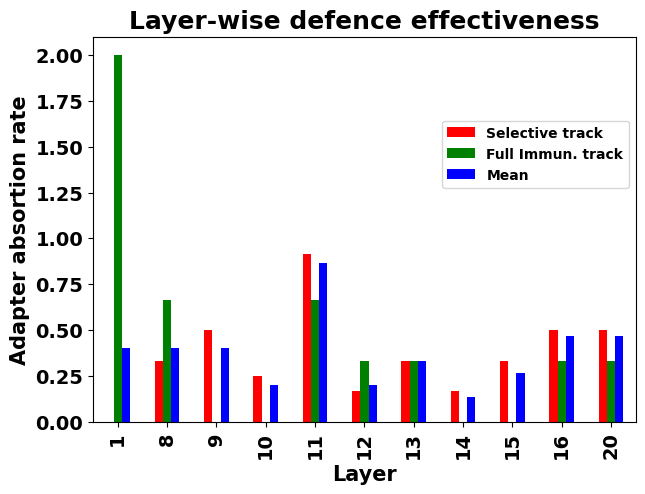

In [645]:

# Define custom colors for the bars
colors = ['red', 'green', 'blue']  # Example colors


absorb_ds.plot(kind='bar', legend=True, color=colors, figsize=(7, 5))
"""
plt.plot(layer_defence_likelihood['Defence absortion rate'], 
         marker='*', 
         lw=3, 
         color='green', 
         label='Defence absortion rate')
"""

plt.xticks(fontsize=14, fontweight='bold')

plt.yticks(fontsize=14, fontweight='bold')

plt.xlabel('Layer', fontdict=axis_font_dict)
plt.ylabel('Adapter absortion rate', fontdict=axis_font_dict)
plt.title(f'Layer-wise defence effectiveness', fontdict=title_font_dict)

plt.legend(
    prop=legend_font_dict,
    bbox_to_anchor=(1, 0.8),
    loc='upper right')
plt.show()

The mean defence effectiveness was measured for each layer in terms of the absorion rate of defence modules. A defence module is absorbed if and only if the resultant evaluation performance and safety is above the corresponding tresholds. "Selective track" refers to immunization iterations that started from a different layers with respect to the initial one. "Full" indicates runs that started from layer 0 (with different seeds) "Mean" computes the absortion rate taking into account both the selective and full immunization rounds. 